# Exploration of Methods for Noise Reduction in Medical Images
## Machine Learning 

### Bassan Davide


### Architecture

- CPU: AMD Ryzen 5 3600
- GPU: NVIDIA RTX 3060 12GB
- RAM: 48GB
- OS: Linux Ubuntu 20.04.6 LTS

In [1]:
import tensorflow as tf

2024-06-27 10:54:51.331179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 10:54:52.634806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


## Introduction
This project explores techniques for reducing noise in medical images using both traditional and deep learning approaches. The aim is to improve image quality for more accurate diagnosis and analysis. The methodologies employed include noise analysis, noise addition, and various denoising techniques, culminating in two deep learning models for effective noise reduction.

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, color, util
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim
from scipy.stats import kurtosis, entropy
from tqdm import tqdm
import seaborn as sns
import cv2 
import pywt
from skimage.metrics import structural_similarity as compare_ssim

In [4]:
def load_image(image_path):
    return np.array(Image.open(image_path).convert('L')) 

## Dataset Exploration
The dataset used in this study is sourced from the CBIS-DDSM (Curated Breast Imaging Subset of DDSM) Breast Cancer Image Dataset, available at https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset.

This dataset contains a collection of mammography images used for breast cancer detection and diagnosis 

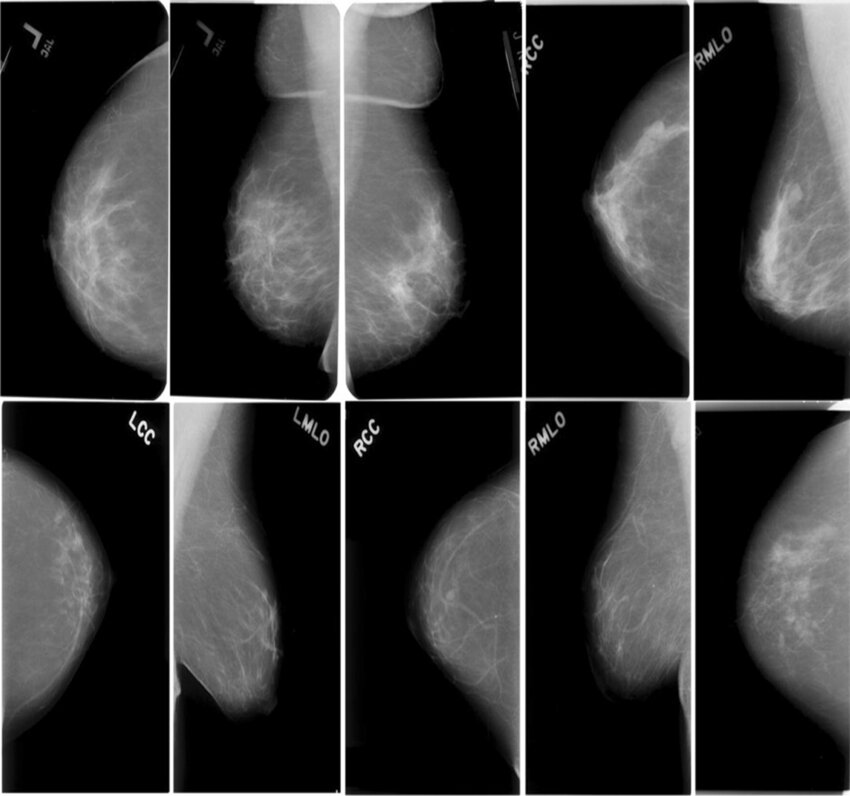

This function calculates some statistical properties of an image.

- **Mean**: This is the average value of all pixels in the image. For grayscale images, it represents the average intensity level.

- **Standard Deviation (Std)**: This measures the spread of pixel values around the mean. A higher standard deviation indicates more variation in the image intensity.

- **Kurtosis**: This metric describes the distribution of pixel values in the image. A kurtosis value of 3 indicates a normal distribution. Values greater than 3 suggest a distribution with more extreme values (peaks or dips) compared to a normal distribution. Lower values indicate a flatter distribution.

- **Entropy**: This metric quantifies the information content in the image. Higher entropy indicates a more complex image with more variations in pixel values. Lower entropy suggests a simpler image with fewer variations.

In [5]:
def calculate_statistics(image):
    arr = np.array(image)
    mean = np.mean(arr)
    std = np.std(arr)
    kurt = kurtosis(arr.flatten())
    ent = entropy(arr.flatten())
    return mean, std, kurt, ent

This function calculates three common image quality metrics to assess the quality of a denoised image compared to its original **clean*** version. 

- **Peak Signal-to-Noise Ratio (PSNR)**:
PSNR is a common metric used to measure the quality of a reconstructed image compared to the original. Higher PSNR values indicate better quality, with a perfect reconstruction achieving an infinite PSNR. It measures the ratio between the maximum possible pixel value (usually 255 for grayscale images) and the mean squared error (MSE) between the original and noisy images.

- **Mean Squared Error (MSE)**:
MSE is a fundamental metric that calculates the average squared difference between corresponding pixels in the original and noisy images. Lower MSE values indicate a smaller difference between the images and potentially better denoising performance.

- **Structural Similarity Index Measure (SSIM)**:
SSIM goes beyond just pixel-wise differences and considers the structural similarity between the original and noisy images. It incorporates luminance, contrast, and structure comparison, potentially providing a more nuanced evaluation of image quality, especially for images with similar overall intensity but structural differences.

**Working under the assumption that the original images are clean and without any type of noise.*

In [6]:
def calculate_quality_metrics(original, noisy):
    original_arr = np.array(original)
    noisy_arr = np.array(noisy)
    psnr_value = psnr(original_arr, noisy_arr)
    mse_value = mse(original_arr, noisy_arr)
    ssim_value = ssim(original_arr, noisy_arr)
    return psnr_value, mse_value, ssim_value

In [7]:
dicom_data = pd.read_csv('DATA/csv/dicom_info.csv')
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
image_dir = 'DATA/jpeg'
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))


In [8]:
cropped_images = cropped_images[cropped_images.apply(os.path.exists)]
num_images = len(cropped_images)
print(f'Number of valid cropped images: {num_images}')

Number of valid cropped images: 3567


## Analisys of Noise

### Noise Application Function
In the provided function `apply_noise_combinations`, three types of noise are applied to an input image. These types of noise are:

1. **Gaussian Noise**: This simulates random variations in the image's intensity values, often resembling a speckled or grainy appearance.
2. **Salt and Pepper Noise**: This introduces random black and white pixels into the image, simulating the effect of data transmission errors.
3. **Poisson Noise**: This type of noise, also known as shot noise, is caused by variations in the number of photons hitting the image sensor.

Due to time and resource constraints, the experiments were conducted using only these three types of noise. The function generates noisy images by applying each type of noise individually to simulate different real-world scenarios. 

In medical imaging, these types of noise can occur as follows:

- **Gaussian Noise**: This can occur due to electronic circuit noise during image acquisition or transmission.
- **Salt and Pepper Noise**: This can result from data corruption during transmission or storage, especially in digital imaging.
- **Poisson Noise**: This is common in low-light imaging conditions, where the number of photons reaching the sensor is low and varies randomly.

By simulating these noises, the function helps in evaluating the robustness of image processing algorithms under different noise conditions.

Further experiments can be conducted using combinations of these noises, or modifying the amount of noise. For example, using all possible combinations:

```python
combinations = [
    ('Gaussian',),
    ('Salt and Pepper',),
    ('Poisson',),
    ('Gaussian', 'Salt and Pepper'),
    ('Gaussian', 'Poisson'),
    ('Salt and Pepper', 'Poisson'),
    ('Gaussian', 'Salt and Pepper', 'Poisson')
]
```

Other types of noise that can be present in medical images include:

- **Speckle Noise**: Often found in ultrasound images, caused by the interference of sound waves.
- **Quantization Noise**: Occurs when the intensity levels of an image are reduced during compression.
- **Brownian Noise (or Red Noise)**: This noise has a power density that decreases with increasing frequency, resembling natural processes.

By exploring these additional noise types and their combinations, we can further enhance the robustness and reliability of image processing techniques.

In [9]:
def apply_noise_combinations(img):
    noises = {
        'Gaussian': lambda img: util.random_noise(np.array(img), mode='gaussian', var=0.001),
        'Salt and Pepper': lambda img: util.random_noise(np.array(img), mode='s&p', amount=0.005),
        'Poisson': lambda img: util.random_noise(np.array(img), mode='poisson')
    }

    combinations = [
        ('Gaussian',),
        ('Salt and Pepper',),
        ('Poisson',),
    ]

    noisy_images = {}
    for combo in combinations:
        combined_noise = np.array(img)
        for noise_type in combo:
            combined_noise = noises[noise_type](combined_noise)
        noisy_img = Image.fromarray((combined_noise * 255).astype(np.uint8))
        noisy_images[' + '.join(combo)] = noisy_img
    
    return noisy_images

In [10]:
statistics = []
quality_metrics = []

In [11]:
def preprocess_image(image_path):
    image = io.imread(image_path, as_gray=True)
    
    h, w = image.shape
    start_h = (h - 64) // 2
    start_w = (w - 64) // 2
    
    cropped_image = image[start_h:start_h+64, start_w:start_w+64]
    
    return cropped_image


> **⚠️ Warning** 
>
> **Attention: This chunk might take a long time to execute depending on the computer's performance.**

In [12]:
images_for_denoising = []
image_index = 0 

for file in tqdm(cropped_images):
    img = preprocess_image(file)
    
    mean, std, kurt, ent = calculate_statistics(img)
    statistics.append((image_index, mean, std, kurt, ent, 'Original'))
    
    images_for_denoising.append((img, 'Original', image_index))
    
    noisy_images = apply_noise_combinations(img)
    for noise_type, noisy_img in noisy_images.items():
        
        mean, std, kurt, ent = calculate_statistics(noisy_img)
        statistics.append((image_index, mean, std, kurt, ent, noise_type))
        
        images_for_denoising.append((noisy_img, noise_type, image_index))
        
        psnr_value, mse_value, ssim_value = calculate_quality_metrics(img, noisy_img)
        quality_metrics.append((image_index, psnr_value, mse_value, ssim_value, noise_type))
    
    image_index += 1

100%|██████████| 3567/3567 [02:22<00:00, 24.97it/s]


In [13]:
statistics_df = pd.DataFrame(statistics, columns=['Image ID', 'Mean', 'Std Dev', 'Kurtosis', 'Entropy', 'Noise Type'])
quality_metrics_df = pd.DataFrame(quality_metrics, columns=['Image ID', 'PSNR', 'MSE', 'SSIM', 'Noise Type'])

In [14]:
statistics_df.to_csv('statistics.csv', index=False)
quality_metrics_df.to_csv('quality_metrics.csv', index=False)

This code snippet creates the dataset. 

For each cropped image, additional copies are saved with noise added based on predefined combinations. Due to computational constraints, **only one 64x64 patch is taken from each image**. 

Note that the 64x64 patch is taken from the center of the image. While this is not the optimal approach and better results could be achieved by considering all 64x64 patches or the entire image, it provides a balance between computational efficiency and model performance.

In [15]:
image_groups = {}
for img, label, img_id in images_for_denoising:
    if label == 'Original':
        image_groups[img_id] = {'Original': img}
    else:
        if img_id in image_groups:
            image_groups[img_id][label] = img

for group_index, images in image_groups.items():
    original_img = Image.fromarray(images['Original'])
    original_img.save(f'image_dataset_64x64/{group_index}_Original.jpg')
    
    for noise_label, noisy_img in images.items():
        if noise_label != 'Original':
            noisy_img.save(f'image_dataset_64x64/{group_index}_{noise_label}.jpg')

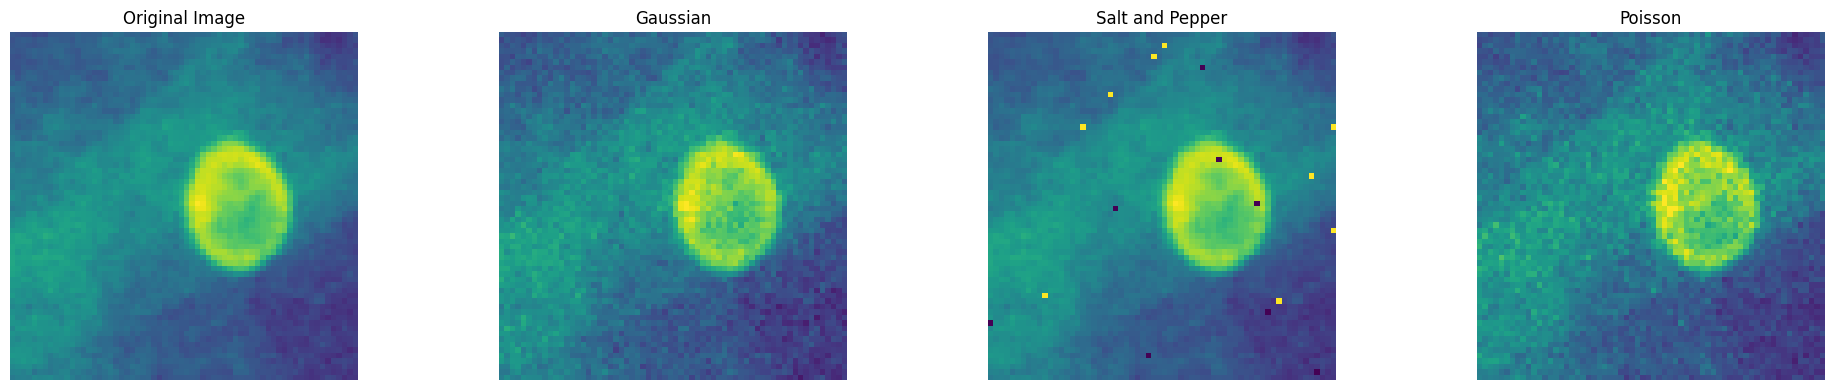

In [16]:
file = cropped_images.iloc[1]
img = preprocess_image(file)

noisy_images = apply_noise_combinations(img)

fig, axes = plt.subplots(1, len(noisy_images) + 1, figsize=(20, 4))

axes[0].imshow(img, cmap='viridis', vmin=0, vmax=255)
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, (noise_type, noisy_img) in enumerate(noisy_images.items(), 1):
    axes[i].imshow(noisy_img, cmap='viridis', vmin=0, vmax=255)
    axes[i].set_title(f'{noise_type}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [17]:
original_stats = statistics_df[statistics_df['Noise Type'] == 'Original']
noisy_stats = statistics_df[statistics_df['Noise Type'] != 'Original']

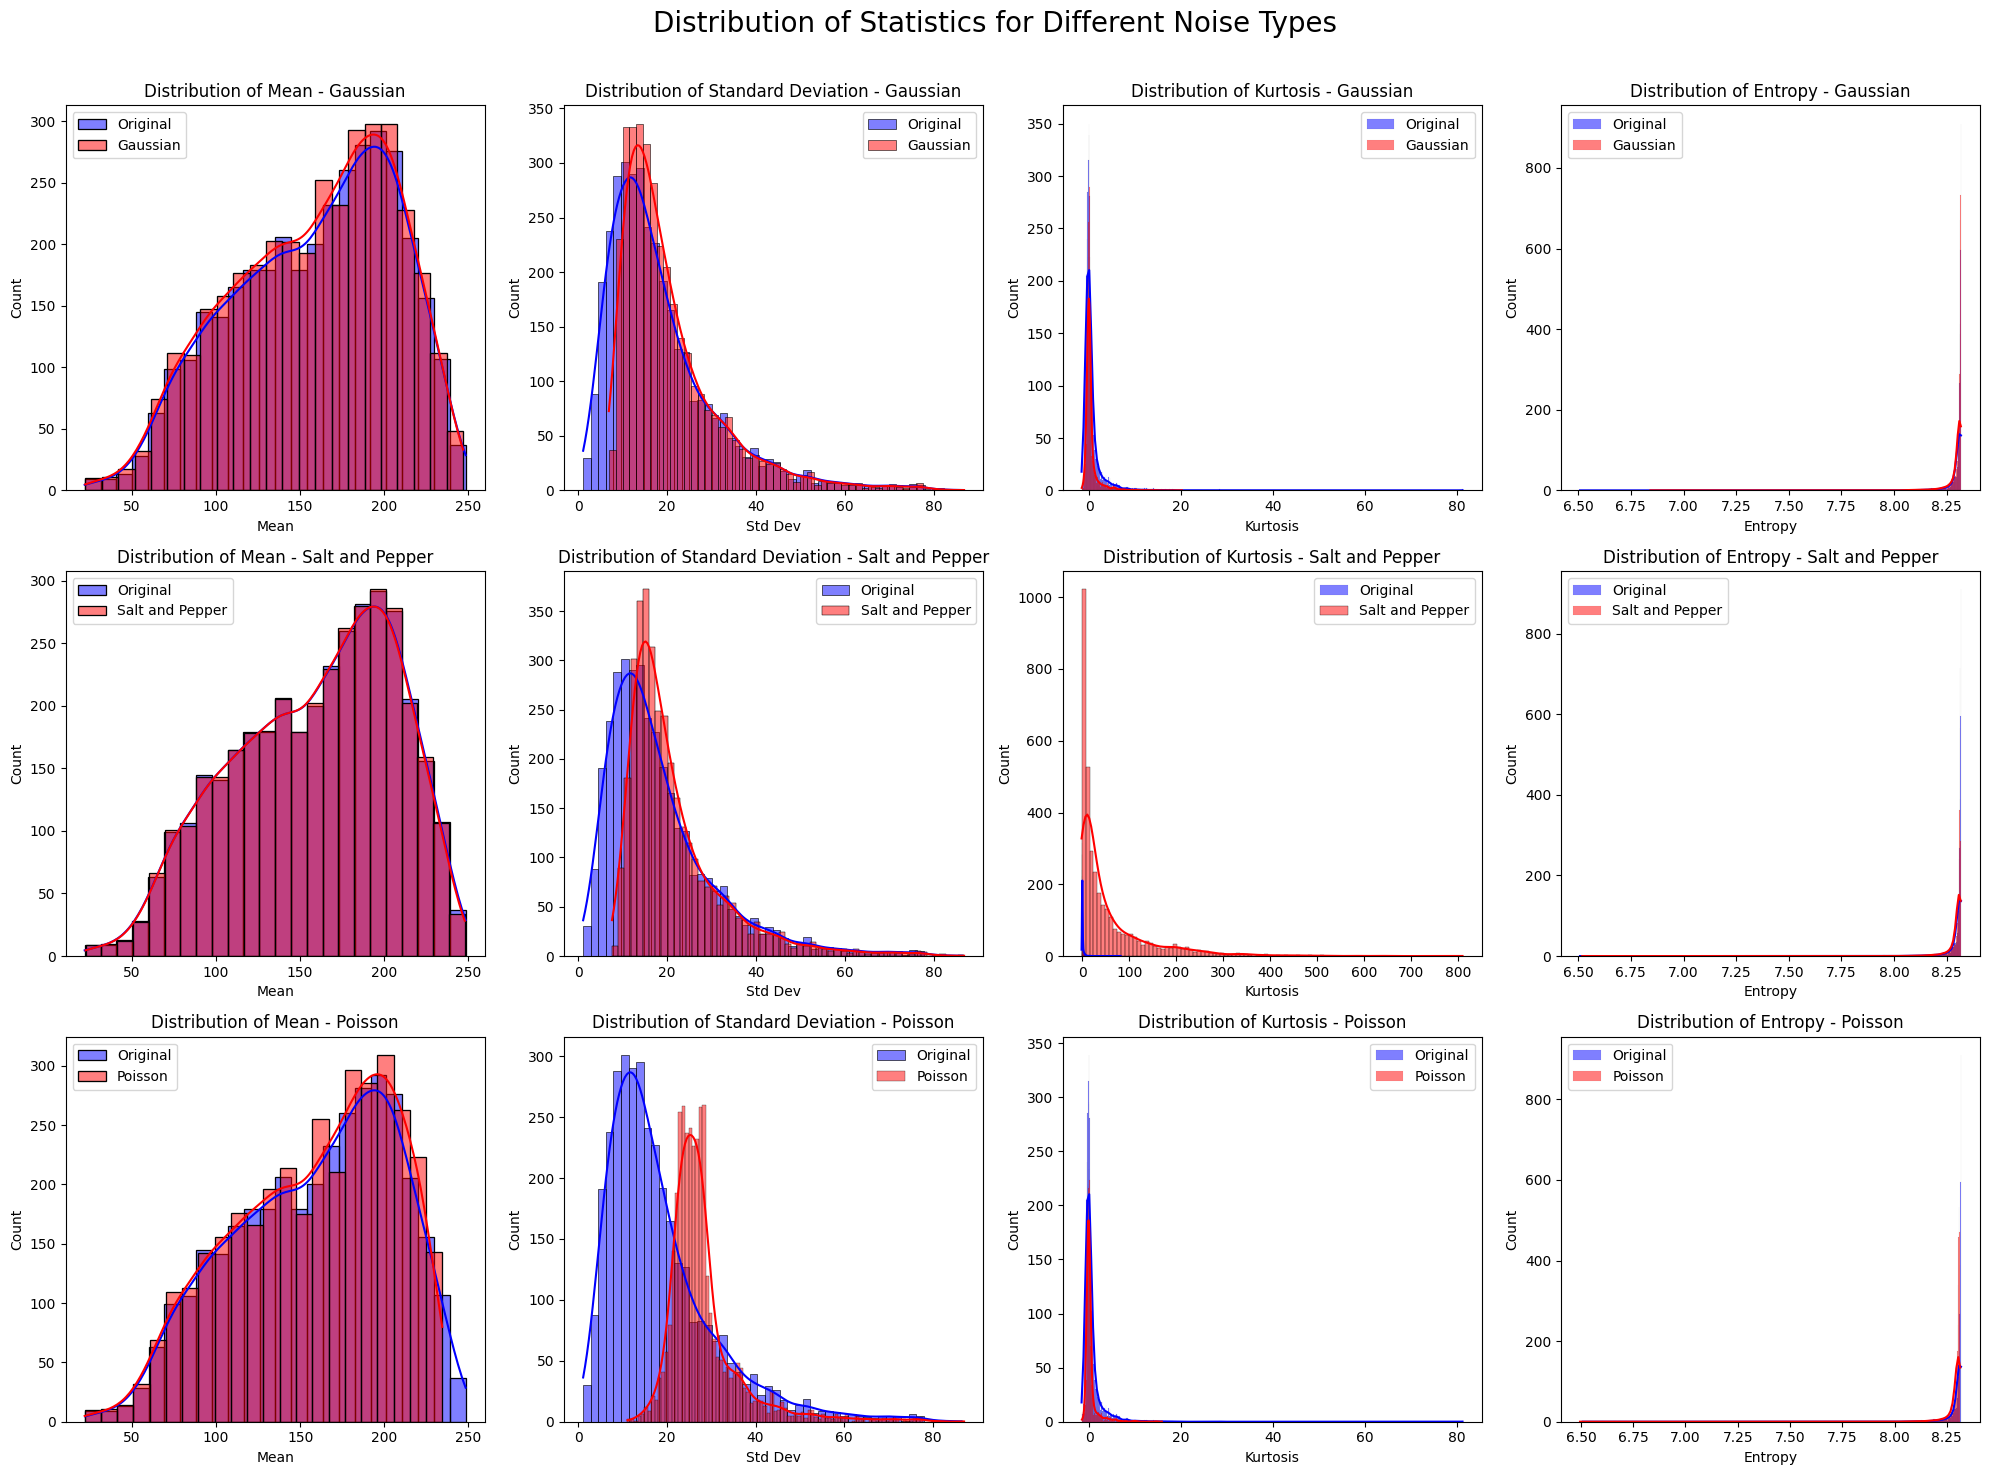

In [18]:
noise_types = noisy_stats['Noise Type'].unique()

fig, axes = plt.subplots(len(noise_types), 4, figsize=(20, len(noise_types) * 5))
fig.suptitle('Distribution of Statistics for Different Noise Types', fontsize=20)

for i, noise_type in enumerate(noise_types):
    noisy_stats_type = noisy_stats[noisy_stats['Noise Type'] == noise_type]
    
    sns.histplot(original_stats['Mean'], kde=True, ax=axes[i, 0], color='blue', label='Original')
    sns.histplot(noisy_stats_type['Mean'], kde=True, ax=axes[i, 0], color='red', label=noise_type)
    axes[i, 0].set_title(f'Distribution of Mean - {noise_type}')
    axes[i, 0].legend()

    sns.histplot(original_stats['Std Dev'], kde=True, ax=axes[i, 1], color='blue', label='Original')
    sns.histplot(noisy_stats_type['Std Dev'], kde=True, ax=axes[i, 1], color='red', label=noise_type)
    axes[i, 1].set_title(f'Distribution of Standard Deviation - {noise_type}')
    axes[i, 1].legend()

    sns.histplot(original_stats['Kurtosis'], kde=True, ax=axes[i, 2], color='blue', label='Original')
    sns.histplot(noisy_stats_type['Kurtosis'], kde=True, ax=axes[i, 2], color='red', label=noise_type)
    axes[i, 2].set_title(f'Distribution of Kurtosis - {noise_type}')
    axes[i, 2].legend()

    sns.histplot(original_stats['Entropy'], kde=True, ax=axes[i, 3], color='blue', label='Original')
    sns.histplot(noisy_stats_type['Entropy'], kde=True, ax=axes[i, 3], color='red', label=noise_type)
    axes[i, 3].set_title(f'Distribution of Entropy - {noise_type}')
    axes[i, 3].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


- **Mean Distribution**: For all noise types, the mean values of the noisy images (red) are closely aligned with those of the original images (blue). This indicates that adding noise does not significantly shift the central tendency of the pixel values.

- **Standard Deviation Distribution**: The standard deviation is higher for noisy images across all noise types compared to the originals, indicating increased variability and dispersion in pixel values due to the noise.
Gaussian and Salt and Pepper noise show a less noticeable shift in the distribution compared to Poisson noise.

- **Kurtosis Distribution:**  Salt and Pepper noise increases the kurtosis compared to the original, while Gaussian and Poisson noise might slightly decrease it.

- **Entropy Distribution:** Based on visual inspection of the graphs, the entropy, which measures the randomness in the image, appears to be relatively constant between original and noisy images for all noise types.

/tmp/ipykernel_2740407/836288681.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/836288681.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/836288681.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


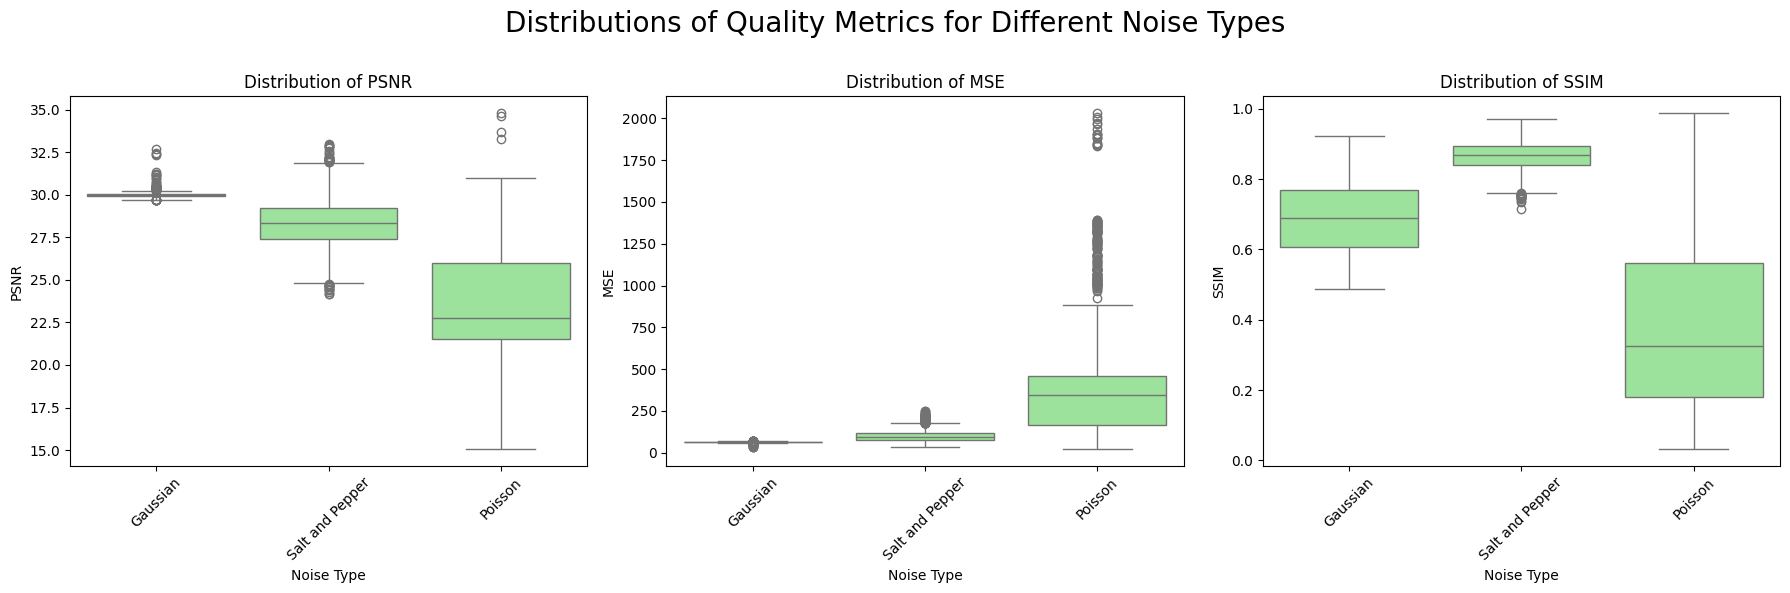

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for Different Noise Types', fontsize=20)

sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_df, ax=axes[0], color='lightgreen')
axes[0].set_title('Distribution of PSNR')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of MSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_df, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of SSIM')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


- **PSNR Distribution**: The PSNR (Peak Signal-to-Noise Ratio) metric quantifies the degradation introduced by noise. Higher PSNR values generally indicate less degradation. The PSNR distribution suggests that Gaussian and Salt-and-Pepper noise lead to less degradation compared to Poisson noise. This implies that the original signal remains more faithful in images corrupted with these two types of noise.

- **MSE Distribution**: Consistent with the previous point, the scatter plot suggests that the MSE distribution exhibits a less pronounced increase for Gaussian and Salt-and-Pepper noise compared to Poisson noise. This further supports the notion that these two noise types introduce less error into the signal.

- **SSIM Distribution**: As with PSNR and MSE, the decrease in SSIM distribution is likely less substantial for Gaussian and Salt-and-Pepper noise compared to Poisson noise. This indicates that these two types of noise preserve the image structure to a greater extent than Poisson noise.

## Denoising using classic methods

The current approach is to use simple filters for denoising and define a baseline. In particular, the following filters will be tested:

- Mean Filter
- Median Filter
- Wavelet Filter
- Anisotropic Filter

and their SSIM, PSNR, and MSE will be compared.

In [20]:
statistics_df = pd.read_csv('statistics.csv')
quality_metrics_df = pd.read_csv('quality_metrics.csv')

In [21]:
dataset_folder = 'image_dataset_64x64'
original_images = {}

In [22]:
def plot_images(original, noisy, denoised, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    axes[0].imshow(original, cmap='viridis', vmin=0, vmax=255)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(noisy, cmap='viridis', vmin=0, vmax=255)
    axes[1].set_title('Noisy Image')
    axes[1].axis('off')
    
    axes[2].imshow(denoised, cmap='viridis', vmin=0, vmax=255)
    axes[2].set_title('Denoised Image')
    axes[2].axis('off')
    
    plt.show()

In [23]:
for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = load_image(image_path)

        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type == 'Original':
            original_images[image_index] = image


100%|██████████| 14268/14268 [00:03<00:00, 3637.20it/s]


### Mean denoising

Mean denoising works by replacing the value of a pixel with the average value of its surrounding pixels within the defined neighborhood. This averaging process aims to smooth out the noise by replacing extreme values with more representative values from the local area.

In [24]:
def mean_denoising(image, neighborhood_size=3):
    denoised_image = cv2.blur(np.array(image), (neighborhood_size, neighborhood_size))
    return denoised_image

In [25]:
statistics_mean_denoising = []
quality_metrics_mean_denoising = []

In [26]:
for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = load_image(image_path)
        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type != 'Original':
            denoised_img = mean_denoising(image)

            mean, std, kurt, ent = calculate_statistics(denoised_img)
            statistics_mean_denoising.append((image_index, mean, std, kurt, ent, noise_type))

            original_img = original_images.get(image_index, None)
            if original_img is not None:
                psnr_value, mse_value, ssim_value = calculate_quality_metrics(original_img, denoised_img)
                quality_metrics_mean_denoising.append((image_index, psnr_value, mse_value, ssim_value, noise_type))


100%|██████████| 14268/14268 [00:16<00:00, 851.71it/s]


In [27]:
statistics_mean_denoising_df = pd.DataFrame(statistics_mean_denoising, columns=['Image ID', 'Mean', 'Std Dev', 'Kurtosis', 'Entropy', 'Noise Type'])
quality_metrics_mean_denoising_df = pd.DataFrame(quality_metrics_mean_denoising, columns=['Image ID', 'PSNR', 'MSE', 'SSIM', 'Noise Type'])

In [28]:
statistics_mean_denoising_df.to_csv('statistics_mean_denoising.csv', index=False)
quality_metrics_mean_denoising_df.to_csv('quality_metrics_mean_denoising.csv', index=False)

/tmp/ipykernel_2740407/1071576687.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/1071576687.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/1071576687.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


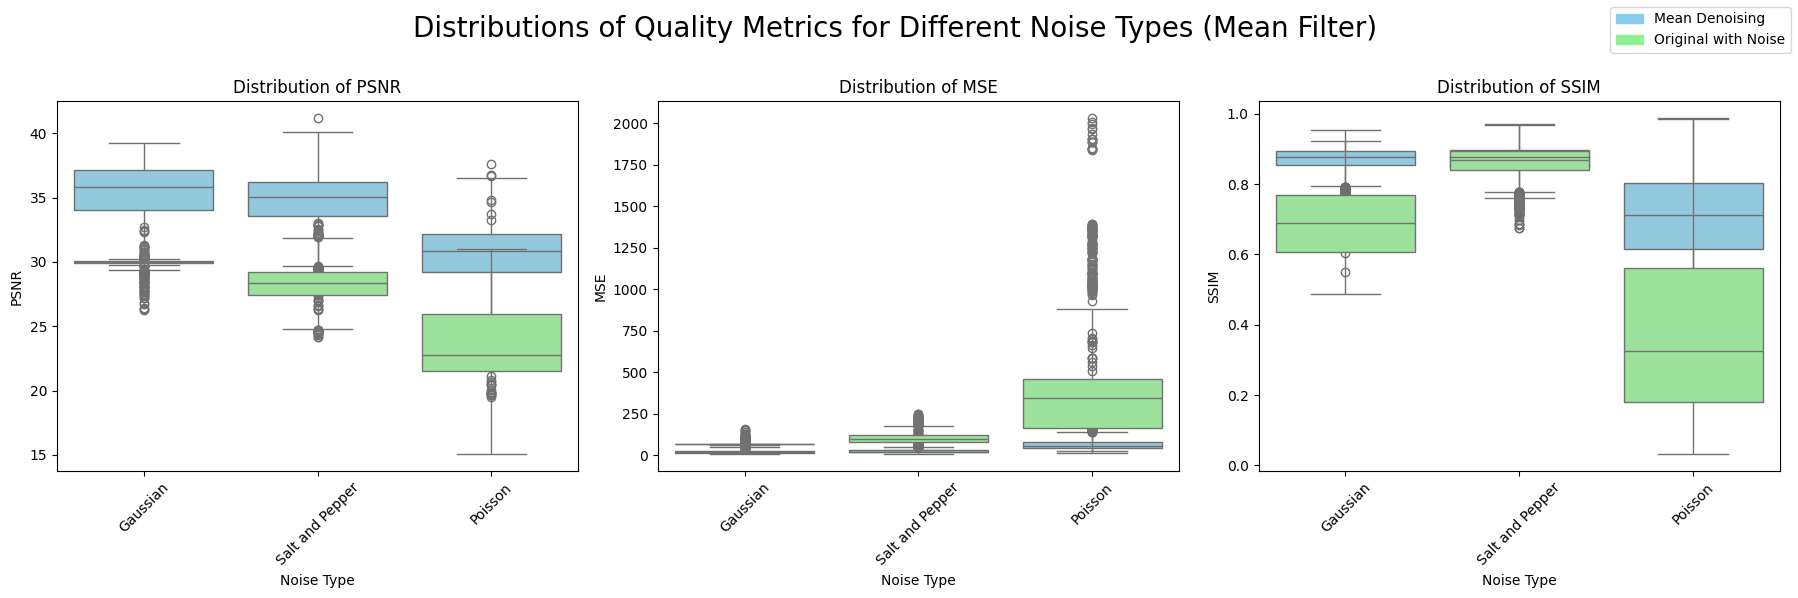

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['skyblue', 'lightgreen', 'lightcoral']

order = ['Gaussian', 'Salt and Pepper', 'Poisson']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for Different Noise Types (Mean Filter)', fontsize=20)

sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_mean_denoising_df, ax=axes[0], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_df, ax=axes[0], color=colors[1], order=order)
axes[0].set_title('Distribution of PSNR')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_mean_denoising_df, ax=axes[1], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_df, ax=axes[1], color=colors[1], order=order)
axes[1].set_title('Distribution of MSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_mean_denoising_df, ax=axes[2], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_df, ax=axes[2], color=colors[1], order=order)
axes[2].set_title('Distribution of SSIM')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors[:2]]
labels = ['Mean Denoising', 'Original with Noise']
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


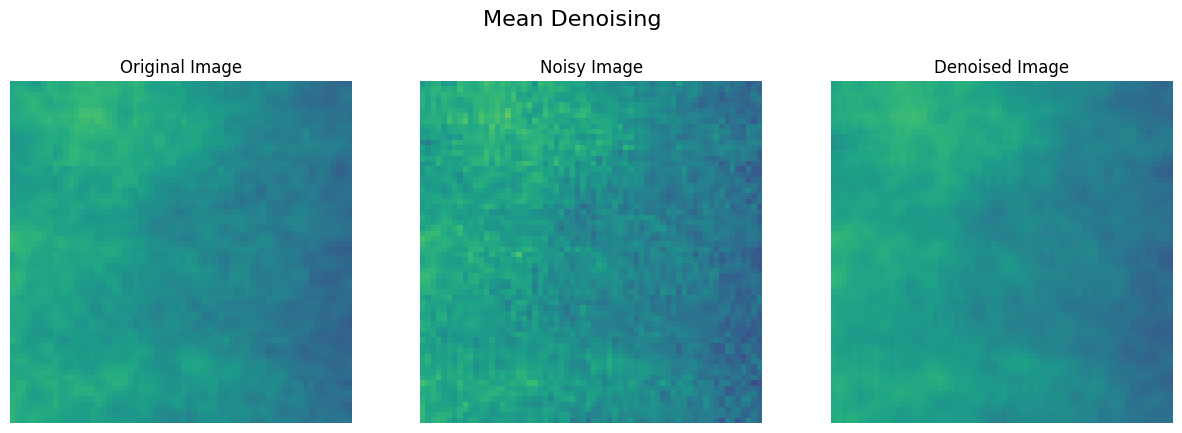

In [30]:
example_image_index = list(original_images.keys())[6]
original_image = original_images[example_image_index]
noisy_image_path = os.path.join(dataset_folder, f"{example_image_index}_Gaussian.jpg")
noisy_image = load_image(noisy_image_path)
denoised_image = mean_denoising(np.array(noisy_image))
plot_images(original_image, noisy_image, denoised_image, title='Mean Denoising')

**Limitations**:

This simple approach might blur edges and fine details along with the noise, potentially leading to a loss of image sharpness.
It may not be very effective for complex noise patterns.

### Median Denoising

Median filtering works by sorting the intensity values of pixels in a local neighborhood (defined by neighborhood_size). The median value, which represents the "middle" value in the sorted list, is then used to replace the central pixel's value in the image.

In [31]:
def median_denoising(image, neighborhood_size=3):
    denoised_image = cv2.medianBlur(np.array(image), neighborhood_size)
    return denoised_image

In [32]:
statistics_median_denoising = []
quality_metrics_median_denoising = []

In [33]:
for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = load_image(image_path)
        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type != 'Original':
            denoised_img = median_denoising(image)

            mean, std, kurt, ent = calculate_statistics(denoised_img)
            statistics_median_denoising.append((image_index, mean, std, kurt, ent, noise_type))

            original_img = original_images.get(image_index, None)
            if original_img is not None:
                psnr_value, mse_value, ssim_value = calculate_quality_metrics(original_img, denoised_img)
                quality_metrics_median_denoising.append((image_index, psnr_value, mse_value, ssim_value, noise_type))


100%|██████████| 14268/14268 [00:16<00:00, 850.59it/s]


In [34]:
statistics_median_denoising_df = pd.DataFrame(statistics_median_denoising, columns=['Image ID', 'Mean', 'Std Dev', 'Kurtosis', 'Entropy', 'Noise Type'])
quality_metrics_median_denoising_df = pd.DataFrame(quality_metrics_median_denoising, columns=['Image ID', 'PSNR', 'MSE', 'SSIM', 'Noise Type'])

In [35]:
statistics_median_denoising_df.to_csv('statistics_median_denoising.csv', index=False)
quality_metrics_median_denoising_df.to_csv('quality_metrics_median_denoising.csv', index=False)


/tmp/ipykernel_2740407/1459635706.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/1459635706.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/1459635706.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


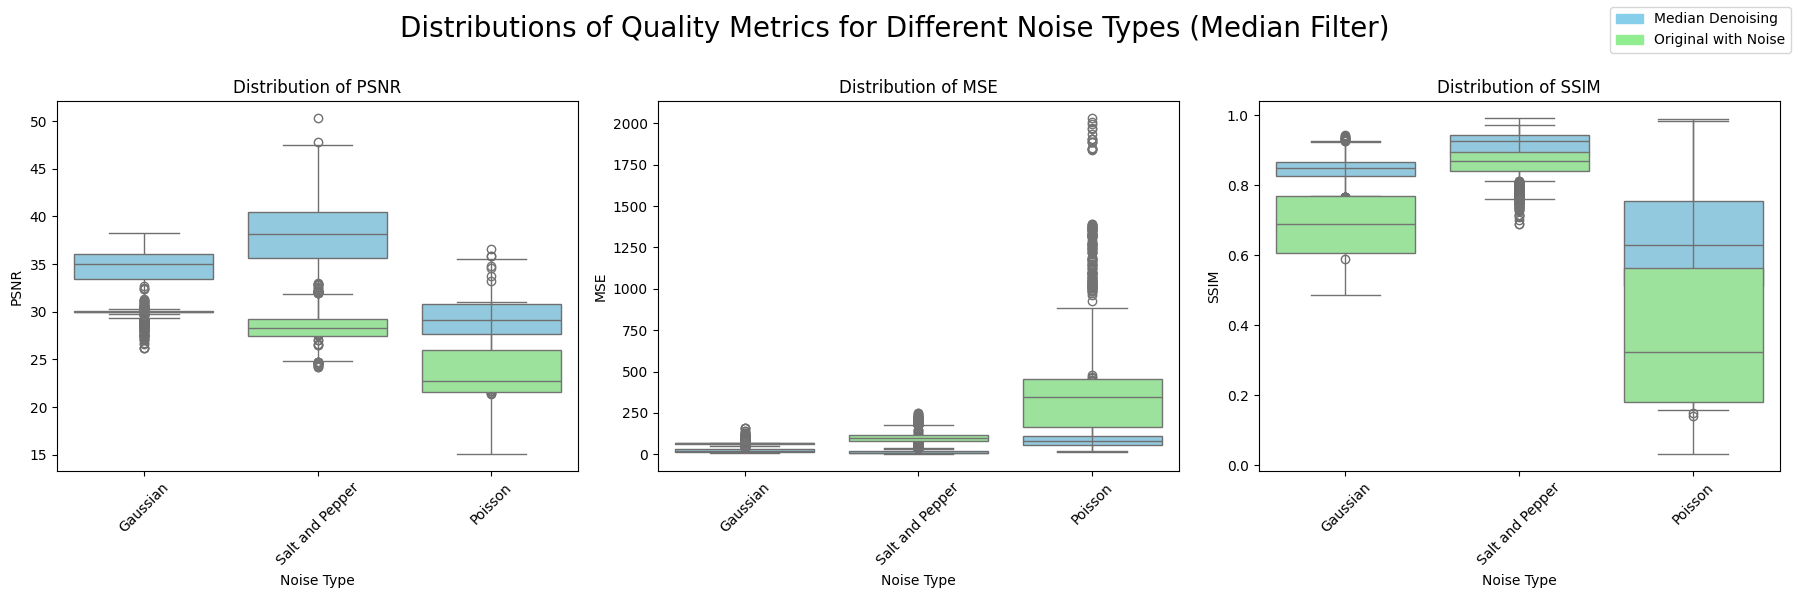

In [36]:
colors = ['skyblue', 'lightgreen', 'lightcoral']

order = ['Gaussian', 'Salt and Pepper', 'Poisson']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for Different Noise Types (Median Filter)', fontsize=20)

sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_median_denoising_df, ax=axes[0], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_df, ax=axes[0], color=colors[1], order=order)
axes[0].set_title('Distribution of PSNR')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_median_denoising_df, ax=axes[1], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_df, ax=axes[1], color=colors[1], order=order)
axes[1].set_title('Distribution of MSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_median_denoising_df, ax=axes[2], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_df, ax=axes[2], color=colors[1], order=order)
axes[2].set_title('Distribution of SSIM')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors[:2]]
labels = ['Median Denoising', 'Original with Noise']
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

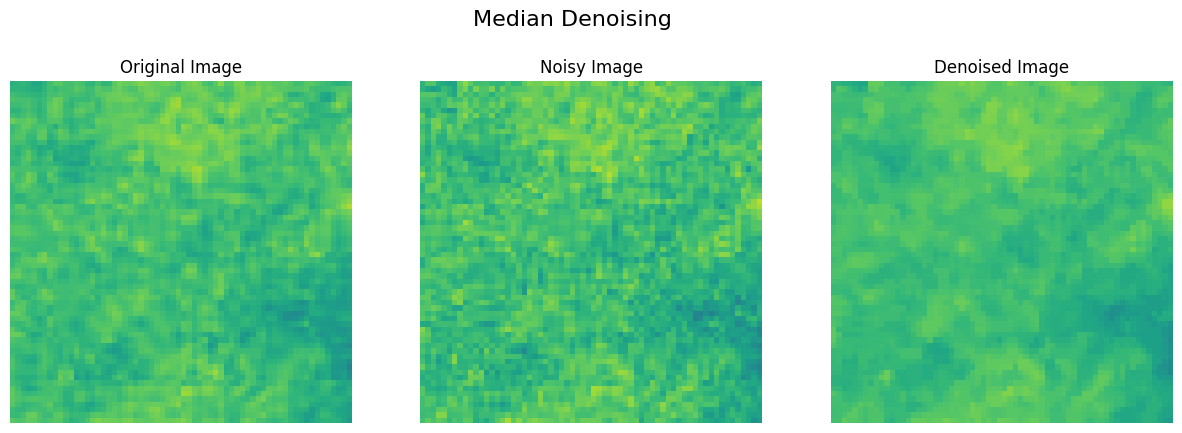

In [37]:
example_image_index = list(original_images.keys())[0]
original_image = original_images[example_image_index]
noisy_image_path = os.path.join(dataset_folder, f"{example_image_index}_Gaussian.jpg")
noisy_image = load_image(noisy_image_path)
denoised_image = median_denoising(np.array(noisy_image))
plot_images(original_image, noisy_image, denoised_image, title='Median Denoising')

**Advantages over Mean Denoising:**

Median filtering is often more effective in preserving edges and fine details compared to mean denoising. This is because the median is less sensitive to extreme values in the neighborhood, unlike the average which can be skewed by outliers.

It's more robust against impulsive noise, which consists of sudden and localized intensity changes (e.g., salt-and-pepper noise). The median value is less likely to be influenced by such outliers compared to the mean.

**Limitations:**

Median filtering might not completely remove all noise, especially for complex noise patterns.

### Wavelet Filter

The Wavelet filter works by decomposing an image into different frequency components using wavelet transforms. This process involves breaking down the image into wavelet coefficients at various scales and orientations. These coefficients represent different details and structures within the image. The denoising is performed by thresholding or modifying these coefficients to suppress the noise while preserving important image features. After processing, the image is reconstructed by applying the inverse wavelet transform, resulting in a denoised image with reduced noise and retained important details.

In [38]:
import pywt

def wavelet_denoising(image, wavelet='bior1.3', level=1, mode='soft'):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    def sure_shrink(coeffs):
        threshold = np.sqrt(2 * np.log(coeffs.size)) * np.median(np.abs(coeffs)) / 0.6745
        return pywt.threshold(coeffs, threshold, mode=mode)
    
    coeffs_list = [coeffs[0]]  
    for detail_coeffs in coeffs[1:]:
        coeffs_list.append(tuple(sure_shrink(c) for c in detail_coeffs))
    
    denoised_image = pywt.waverec2(coeffs_list, wavelet)
    
    if denoised_image.shape[0] > image.shape[0] or denoised_image.shape[1] > image.shape[1]:
        rows_diff = denoised_image.shape[0] - image.shape[0]
        cols_diff = denoised_image.shape[1] - image.shape[1]
        crop_top = rows_diff // 2
        crop_bottom = crop_top + image.shape[0]
        crop_left = cols_diff // 2
        crop_right = crop_left + image.shape[1]
        denoised_image = denoised_image[crop_top:crop_bottom, crop_left:crop_right]
    
    return denoised_image

In [39]:
statistics_wavelet_denoising = []
quality_metrics_wavelet_denoising = []

In [40]:
for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = load_image(image_path)
        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type != 'Original':
            denoised_img = wavelet_denoising(np.array(image))
            denoised_img = denoised_img.astype(np.uint8)
            mean, std, kurt, ent = calculate_statistics(denoised_img)
            statistics_wavelet_denoising.append((image_index, mean, std, kurt, ent, noise_type))

            original_img = original_images.get(image_index, None)
            if original_img is not None:
                psnr_value, mse_value, ssim_value = calculate_quality_metrics(original_img, denoised_img)
                quality_metrics_wavelet_denoising.append((image_index, psnr_value, mse_value, ssim_value, noise_type))

  0%|          | 62/14268 [00:00<00:22, 618.96it/s]/media/davide/Volume/Embeddings/.venv/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_2740407/1014439211.py:11: RuntimeWarning: invalid value encountered in cast
  denoised_img = denoised_img.astype(np.uint8)
100%|██████████| 14268/14268 [00:21<00:00, 671.16it/s]


In [41]:
statistics_wavelet_denoising_df = pd.DataFrame(statistics_wavelet_denoising, columns=['Image ID', 'Mean', 'Std Dev', 'Kurtosis', 'Entropy', 'Noise Type'])
quality_metrics_wavelet_denoising_df = pd.DataFrame(quality_metrics_wavelet_denoising, columns=['Image ID', 'PSNR', 'MSE', 'SSIM', 'Noise Type'])

In [42]:
statistics_wavelet_denoising_df.to_csv('statistics_wavelet_denoising.csv', index=False)
quality_metrics_wavelet_denoising_df.to_csv('quality_metrics_wavelet_denoising.csv', index=False)

/tmp/ipykernel_2740407/2216460007.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/2216460007.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/2216460007.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


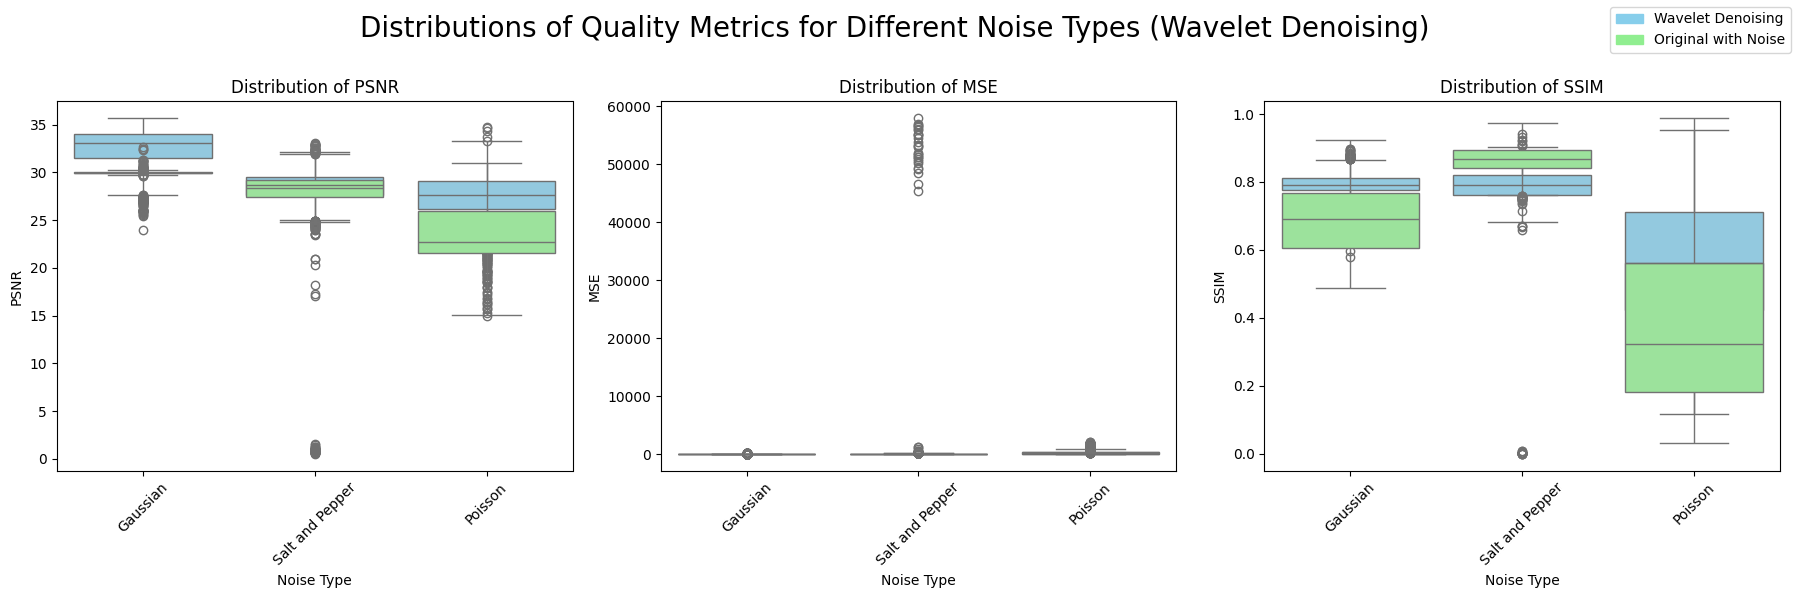

In [43]:

colors = ['skyblue', 'lightgreen', 'lightcoral']

order = ['Gaussian', 'Salt and Pepper', 'Poisson']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for Different Noise Types (Wavelet Denoising)', fontsize=20)

sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_wavelet_denoising_df, ax=axes[0], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_df, ax=axes[0], color=colors[1], order=order)
axes[0].set_title('Distribution of PSNR')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_wavelet_denoising_df, ax=axes[1], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_df, ax=axes[1], color=colors[1], order=order)
axes[1].set_title('Distribution of MSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_wavelet_denoising_df, ax=axes[2], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_df, ax=axes[2], color=colors[1], order=order)
axes[2].set_title('Distribution of SSIM')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors[:2]]
labels = ['Wavelet Denoising', 'Original with Noise']
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

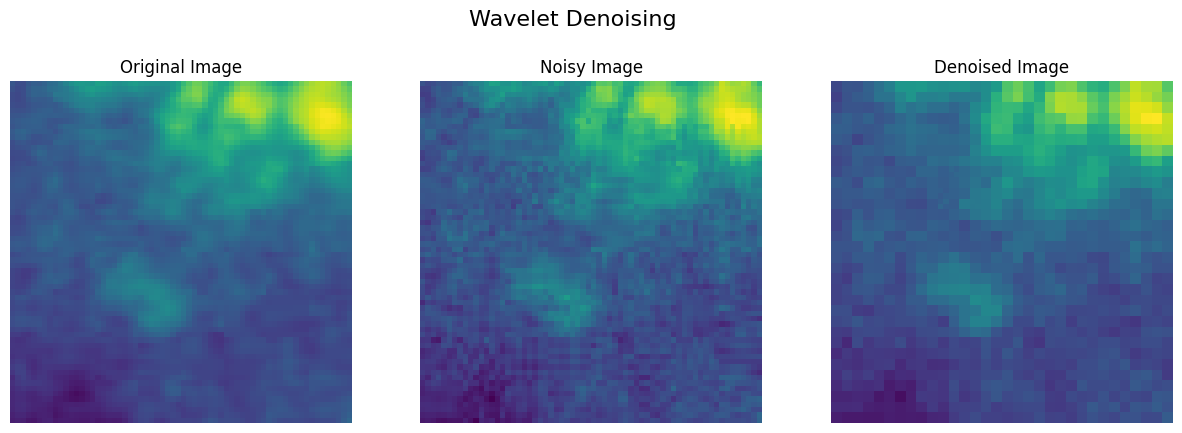

In [44]:
example_image_index = list(original_images.keys())[4]
original_image = original_images[example_image_index]
noisy_image_path = os.path.join(dataset_folder, f"{example_image_index}_Gaussian.jpg")
noisy_image = load_image(noisy_image_path)
denoised_image = wavelet_denoising(np.array(noisy_image), wavelet='haar')
plot_images(original_image, noisy_image, denoised_image, title='Wavelet Denoising')

### Anisotropic Filter

The anisotropic filter works by iteratively smoothing an image while preserving its edges. This process involves applying a partial differential equation (PDE) to the image, which diffuses the pixel intensities. The diffusion coefficient varies based on the image gradient: it is high in homogeneous regions to allow smoothing and low near edges to prevent blurring. The filter reduces noise by diffusing pixel values within regions of similar intensity while maintaining sharp transitions at edges. The result is a denoised image with smoothed regions and preserved edges.

In [45]:
import scipy.ndimage.filters as flt
import warnings


def anisodiff(img, niter=1, kappa=50, gamma=0.1, step=(1., 1.), sigma=0, option=1, ploton=False):
    """
    Anisotropic diffusion.

    Usage:
    imgout = anisodiff(im, niter, kappa, gamma, option)

    Arguments:
            img    - input image
            niter  - number of iterations
            kappa  - conduction coefficient 20-100 ?
            gamma  - max value of .25 for stability
            step   - tuple, the distance between adjacent pixels in (y,x)
            option - 1 Perona Malik diffusion equation No 1
                     2 Perona Malik diffusion equation No 2
            ploton - if True, the image will be plotted on every iteration

    Returns:
            imgout   - diffused image.

    kappa controls conduction as a function of gradient.  If kappa is low
    small intensity gradients are able to block conduction and hence diffusion
    across step edges.  A large value reduces the influence of intensity
    gradients on conduction.

    gamma controls speed of diffusion (you usually want it at a maximum of
    0.25)

    step is used to scale the gradients in case the spacing between adjacent
    pixels differs in the x and y axes

    Diffusion equation 1 favours high contrast edges over low contrast ones.
    Diffusion equation 2 favours wide regions over smaller ones.

    Reference:
    P. Perona and J. Malik.
    Scale-space and edge detection using ansotropic diffusion.
    IEEE Transactions on Pattern Analysis and Machine Intelligence,
    12(7):629-639, July 1990.

    Original MATLAB code by Peter Kovesi
    School of Computer Science & Software Engineering
    The University of Western Australia
    pk @ csse uwa edu au
    <http://www.csse.uwa.edu.au>

    Translated to Python and optimised by Alistair Muldal
    Department of Pharmacology
    University of Oxford
    <alistair.muldal@pharm.ox.ac.uk>

    June 2000  original version.
    March 2002 corrected diffusion eqn No 2.
    July 2012 translated to Python
    """

    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        fig = pl.figure(figsize=(20, 5.5), num="Anisotropic diffusion")
        ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)

        ax1.imshow(img, interpolation='nearest')
        ih = ax2.imshow(imgout, interpolation='nearest', animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in np.arange(1, niter):

        # calculate the diffs
        deltaS[:-1, :] = np.diff(imgout, axis=0)
        deltaE[:, :-1] = np.diff(imgout, axis=1)

        if 0 < sigma:
            deltaSf = flt.gaussian_filter(deltaS, sigma);
            deltaEf = flt.gaussian_filter(deltaE, sigma);
        else:
            deltaSf = deltaS
            deltaEf = deltaE

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaSf / kappa) ** 2.) / step[0]
            gE = np.exp(-(deltaEf / kappa) ** 2.) / step[1]
        elif option == 2:
            gS = 1. / (1. + (deltaSf / kappa) ** 2.) / step[0]
            gE = 1. / (1. + (deltaEf / kappa) ** 2.) / step[1]

        # update matrices
        E = gE * deltaE
        S = gS * deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        # update the image
        imgout += gamma * (NS + EW)

        if ploton:
            iterstring = "Iteration %i" % (ii + 1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout

In [46]:
statistics_anisotropic_denoising = []
quality_metrics_anisotropic_denoising = []

In [47]:
for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = load_image(image_path)
        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type != 'Original':
            denoised_img = anisodiff(np.array(image), niter=10, kappa=20, gamma=0.1)
            denoised_img = denoised_img.astype(np.uint8)
            mean, std, kurt, ent = calculate_statistics(denoised_img)
            statistics_anisotropic_denoising.append((image_index, mean, std, kurt, ent, noise_type))

            original_img = original_images.get(image_index, None)
            if original_img is not None:
                psnr_value, mse_value, ssim_value = calculate_quality_metrics(original_img, denoised_img)
                quality_metrics_anisotropic_denoising.append((image_index, psnr_value, mse_value, ssim_value, noise_type))


100%|██████████| 14268/14268 [00:23<00:00, 607.49it/s]


In [48]:
statistics_anisotropic_denoising_df = pd.DataFrame(statistics_anisotropic_denoising, columns=['Image ID', 'Mean', 'Std Dev', 'Kurtosis', 'Entropy', 'Noise Type'])
quality_metrics_anisotropic_denoising_df = pd.DataFrame(quality_metrics_anisotropic_denoising, columns=['Image ID', 'PSNR', 'MSE', 'SSIM', 'Noise Type'])

In [49]:
statistics_anisotropic_denoising_df.to_csv('statistics_anisotropic_denoising.csv', index=False)
quality_metrics_anisotropic_denoising_df.to_csv('quality_metrics_anisotropic_denoising.csv', index=False)

/tmp/ipykernel_2740407/2341034322.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/2341034322.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
/tmp/ipykernel_2740407/2341034322.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


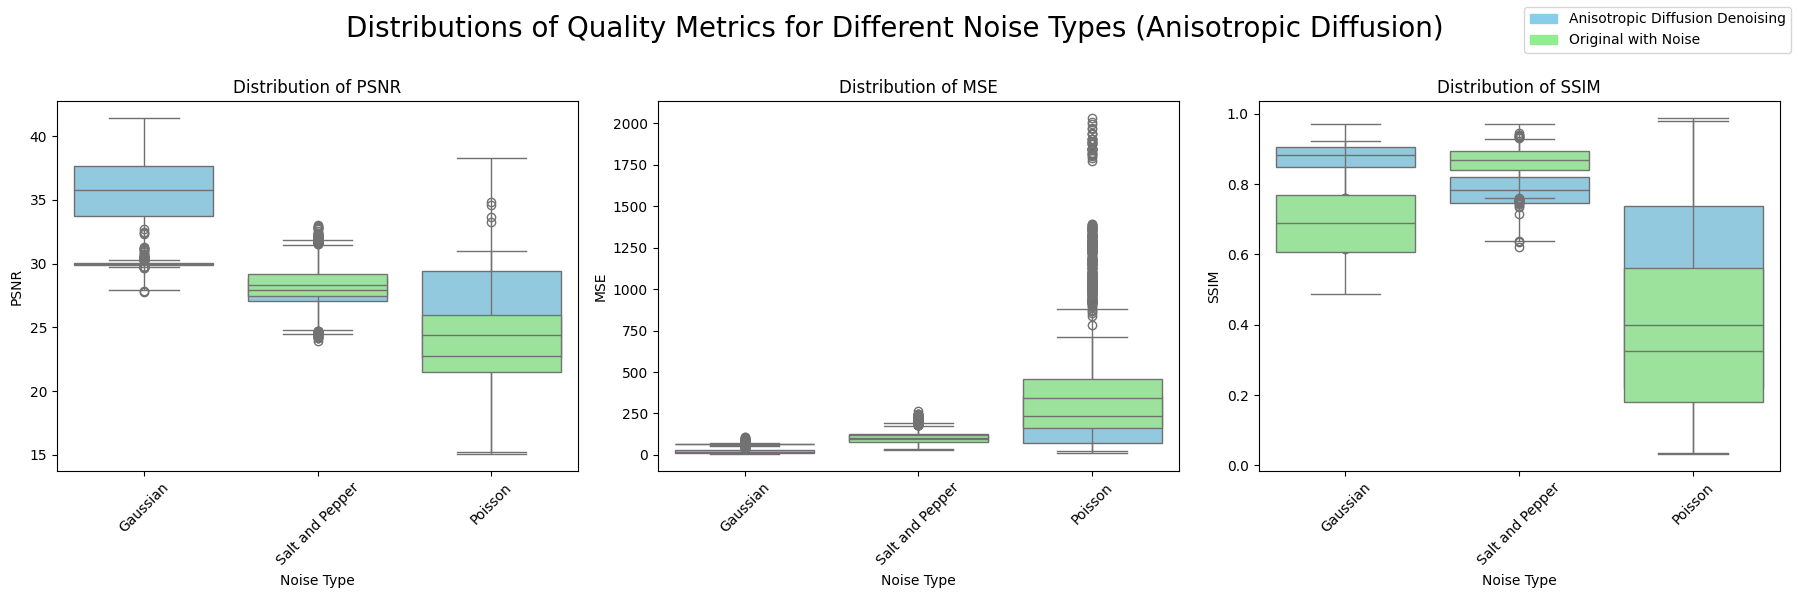

In [50]:
colors = ['skyblue', 'lightgreen', 'lightcoral']
order = ['Gaussian', 'Salt and Pepper', 'Poisson']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for Different Noise Types (Anisotropic Diffusion)', fontsize=20)

sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_anisotropic_denoising_df, ax=axes[0], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='PSNR', data=quality_metrics_df, ax=axes[0], color=colors[1], order=order)
axes[0].set_title('Distribution of PSNR')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_anisotropic_denoising_df, ax=axes[1], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='MSE', data=quality_metrics_df, ax=axes[1], color=colors[1], order=order)
axes[1].set_title('Distribution of MSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_anisotropic_denoising_df, ax=axes[2], color=colors[0], order=order)
sns.boxplot(x='Noise Type', y='SSIM', data=quality_metrics_df, ax=axes[2], color=colors[1], order=order)
axes[2].set_title('Distribution of SSIM')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors[:2]]
labels = ['Anisotropic Diffusion Denoising', 'Original with Noise']
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

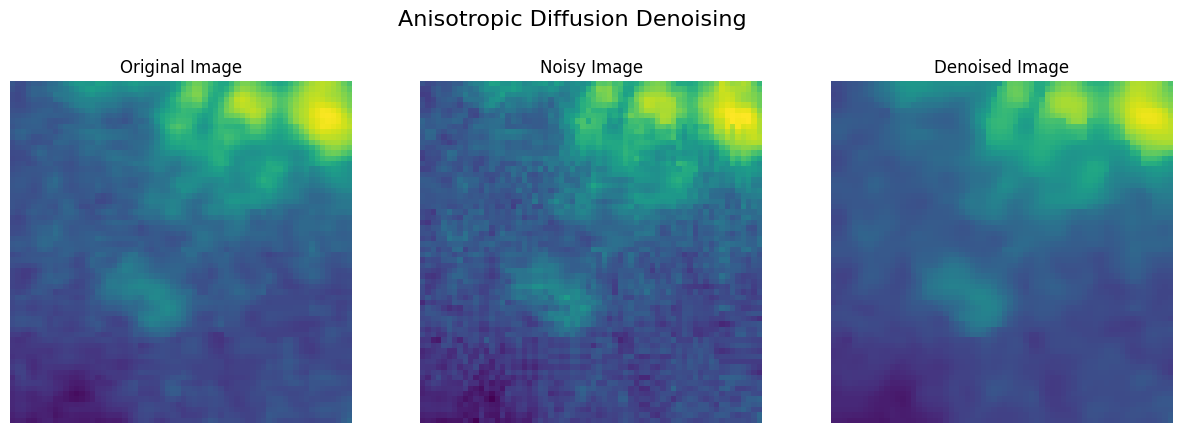

In [51]:
example_image_index = list(original_images.keys())[4]
original_image = original_images[example_image_index]
noisy_image_path = os.path.join(dataset_folder, f"{example_image_index}_Gaussian.jpg")
noisy_image = load_image(noisy_image_path)
denoised_image = anisodiff(np.array(noisy_image), niter=10, kappa=20, gamma=0.1)
plot_images(original_image, noisy_image, denoised_image, title='Anisotropic Diffusion Denoising')

### Final Comparison

In [52]:
from statistics import median

In [53]:
def calculate_metrics_summary(df):
    psnr_median_values = {}
    psnr_mean_values = {}
    mse_median_values = {}
    mse_mean_values = {}
    ssim_median_values = {}
    ssim_mean_values = {}
    
    for noise_type in set(df['Noise Type']):
        psnr_median_values[noise_type] = []
        psnr_mean_values[noise_type] = []
        mse_median_values[noise_type] = []
        mse_mean_values[noise_type] = []
        ssim_median_values[noise_type] = []
        ssim_mean_values[noise_type] = []
    
    for index, row in df.iterrows():
        noise_type = row['Noise Type']
        psnr_value = row['PSNR']
        mse_value = row['MSE']
        ssim_value = row['SSIM']
        
        psnr_median_values[noise_type].append(psnr_value)
        psnr_mean_values[noise_type].append(psnr_value)
        mse_median_values[noise_type].append(mse_value)
        mse_mean_values[noise_type].append(mse_value)
        ssim_median_values[noise_type].append(ssim_value)
        ssim_mean_values[noise_type].append(ssim_value)
    
    median_values = {}
    mean_values = {}
    
    for noise_type in psnr_median_values:
        median_psnr = median(psnr_median_values[noise_type])
        mean_psnr = np.mean(psnr_mean_values[noise_type])
        median_mse = median(mse_median_values[noise_type])
        mean_mse = np.mean(mse_mean_values[noise_type])
        median_ssim = median(ssim_median_values[noise_type])
        mean_ssim = np.mean(ssim_mean_values[noise_type])
        
        median_values[noise_type] = {
            'PSNR': median_psnr,
            'MSE': median_mse,
            'SSIM': median_ssim
        }
        
        mean_values[noise_type] = {
            'PSNR': mean_psnr,
            'MSE': mean_mse,
            'SSIM': mean_ssim
        }
    
    return median_values, mean_values


In [54]:
quality_metrics_df.dtypes

Image ID        int64
PSNR          float64
MSE           float64
SSIM          float64
Noise Type     object
dtype: object

In [55]:
median_mean_denoising = {
    'Mean Denoising': calculate_metrics_summary(quality_metrics_mean_denoising_df),
    'Median Denoising': calculate_metrics_summary(quality_metrics_median_denoising_df),
    'Wavelet Denoising': calculate_metrics_summary(quality_metrics_wavelet_denoising_df),
    'Anisotropic Denoising': calculate_metrics_summary(quality_metrics_anisotropic_denoising_df),
    'Original with Noise': calculate_metrics_summary(quality_metrics_df),
}

In [56]:
for method, (median_vals, mean_vals) in median_mean_denoising.items():
    print(f"Method: {method}")
    print("Median Values:")
    print(median_vals)
    print("Mean Values:")
    print(mean_vals)
    print("\n")

Method: Mean Denoising
Median Values:
{'Salt and Pepper': {'PSNR': 35.00830257729709, 'MSE': 20.5234375, 'SSIM': 0.8777461499689826}, 'Poisson': {'PSNR': 30.861339878695937, 'MSE': 53.326904296875, 'SSIM': 0.7120688723160339}, 'Gaussian': {'PSNR': 35.85340490356093, 'MSE': 16.894287109375, 'SSIM': 0.8778454291787138}}
Mean Values:
{'Salt and Pepper': {'PSNR': 34.744913997547094, 'MSE': 24.9426841040703, 'SSIM': 0.8709939153654034}, 'Poisson': {'PSNR': 30.714217487466396, 'MSE': 64.28516651663688, 'SSIM': 0.6992083158438408}, 'Gaussian': {'PSNR': 35.38894270387539, 'MSE': 22.07320529605148, 'SSIM': 0.8695199258051484}}


Method: Median Denoising
Median Values:
{'Salt and Pepper': {'PSNR': 38.16326343435153, 'MSE': 9.925537109375, 'SSIM': 0.9254939976304203}, 'Poisson': {'PSNR': 29.149100434451153, 'MSE': 79.098876953125, 'SSIM': 0.6288751135336179}, 'Gaussian': {'PSNR': 34.95668981203399, 'MSE': 20.768798828125, 'SSIM': 0.8504877668698437}}
Mean Values:
{'Salt and Pepper': {'PSNR': 37.9

### Poisson Noise

| Method                      | PSNR   | MSE     | SSIM    |
|-----------------------------|--------|---------|---------|
| Mean Denoising - Median     | 30.86  | 53.33   | 0.712   |
| Mean Denoising - Mean       | **30.71**  | **64.29**   | **0.699**   |
| Median Denoising - Median   | 29.15  | 79.10   | 0.629   |
| Median Denoising - Mean     | 29.20  | 90.11   | 0.619   |
| Wavelet Denoising - Median  | 27.65  | 111.83  | 0.560   |
| Wavelet Denoising - Mean    | 27.49  | 138.35  | 0.556   |
| Anisotropic Denoising - Median | 24.41  | 235.42  | 0.398   |
| Anisotropic Denoising - Mean   | 25.47  | 284.80  | 0.455   |
| Original with Noise - Median   | 22.75  | 345.39  | 0.324   |
| Original with Noise - Mean     | 23.40  | 377.96  | 0.376   |

**Mean Denoising performs slightly better than Median Denoising in terms of PSNR and SSIM metrics.**

### Salt and Pepper Noise
| Method                      | PSNR   | MSE     | SSIM    |
|-----------------------------|--------|---------|---------|
| Mean Denoising - Median     | 34.98  | 20.52   | 0.878   |
| Mean Denoising - Mean       | 34.75  | 24.94   | 0.871   |
| Median Denoising - Median   | 38.16  | 9.93    | 0.925   |
| Median Denoising - Mean     | **37.94**  | **14.87**   | **0.913**   |
| Wavelet Denoising - Median  | 28.65  | 88.59   | 0.790   |
| Wavelet Denoising - Mean    | 28.34  | 510.15  | 0.785   |
| Anisotropic Denoising - Median | 27.97  | 103.74  | 0.784   |
| Anisotropic Denoising - Mean   | 27.98  | 108.41  | 0.785   |
| Original with Noise - Median   | 28.34  | 95.34   | 0.868   |
| Original with Noise - Mean     | 28.34  | 100.10  | 0.866   |

**Median Denoising clearly outperforms other methods in terms of PSNR, MSE, and SSIM.**

### Gaussian Noise
| Method                      | PSNR   | MSE     | SSIM    |
|-----------------------------|--------|---------|---------|
| Mean Denoising - Median     | 35.85  | 16.89   | 0.878   |
| Mean Denoising - Mean       | 35.39  | **22.07**   | 0.870   |
| Median Denoising - Median   | 34.95  | 20.77   | 0.850   |
| Median Denoising - Mean     | 34.54  | 25.97   | 0.845   |
| Wavelet Denoising - Median  | 33.04  | 32.29   | 0.792   |
| Wavelet Denoising - Mean    | 32.57  | 39.89   | 0.795   |
| Anisotropic Denoising - Median | 35.78  | 17.19   | 0.882   |
| Anisotropic Denoising - Mean   | **35.58**  | 21.63   | **0.875**   |
| Original with Noise - Median   | 29.99  | 65.17   | 0.690   |
| Original with Noise - Mean     | 30.00  | 65.09   | 0.689   |

**Anisotropic Denoising performs the best with high PSNR and SSIM and low MSE, with results comparable to Mean Denoising.**


## Denoising using DnCNN

*Denoising Convolutional Neural Networks (DnCNN)* are designed to remove noise from images. The key intuition behind DnCNN is that a deep convolutional architecture can learn the characteristics of noise and subtract them from the noisy image, yielding a clean image.

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Input
from tensorflow.keras.models import Model

In [58]:
dataset_folder = "image_dataset_64x64"

In [59]:
def preprocess_image(image_path):
    image = io.imread(image_path, as_gray=True)
    
    image = image / 255.0
    
    return image

In [60]:
train_images = []
target_images = []
noise_types = []

for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_folder, filename)
        image = preprocess_image(image_path)
        parts = filename.split('_')
        image_index = parts[0]
        noise_type = parts[1].split('.')[0]

        if noise_type != 'Original':
            noisy_image = np.expand_dims(image, axis=-1)
            original_image = preprocess_image(os.path.join(dataset_folder, f"{image_index}_Original.jpg"))
            original_image = np.expand_dims(original_image, axis=-1)
            train_images.append(noisy_image)
            target_images.append(original_image)
            noise_types.append(noise_type)

train_images = np.array(train_images)
target_images = np.array(target_images)
noise_types = np.array(noise_types)

train_size = int(0.7 * len(train_images))
val_size = int(0.15 * len(train_images))
test_size = len(train_images) - train_size - val_size


100%|██████████| 14268/14268 [00:16<00:00, 862.67it/s]


In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images[:train_size], target_images[:train_size])).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((train_images[train_size:train_size+val_size], target_images[train_size:train_size+val_size])).batch(32)

2024-06-27 11:06:36.225175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 11:06:36.247444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 11:06:36.247620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [62]:
test_dataset = tf.data.Dataset.from_tensor_slices((train_images[train_size+val_size:], target_images[train_size+val_size:], noise_types[train_size+val_size:])).batch(1)

In [63]:
def plot_history(history):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Generator Loss')
    plt.plot(history['val_loss'], label='Validation Generator Loss')
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['psnr'], label='PSNR', color='green')
    plt.title('PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [64]:
def calculate_metrics_dl(test_ds, generator, batch_size=1):
    metrics = {}

    for batch in tqdm(test_ds, desc="Calculating metrics"):
        input_images, targets, noise_types = batch
        
        generated_images = generator(input_images, training=False)
        
        for i in range(batch_size):
            target = targets[i].numpy()
            generated_image = generated_images[i].numpy().astype('float32')
            noise_type = noise_types[i].numpy().decode('utf-8')
            ssim_score = compare_ssim(target.squeeze(), generated_image.squeeze(), data_range=1.0)
            psnr_score = psnr(target.squeeze(), generated_image.squeeze())
            mse_score = np.mean(np.square(target - generated_image))
            if noise_type not in metrics:
                metrics[noise_type] = {'ssim': [], 'psnr': [], 'mse': []}
            
            metrics[noise_type]['ssim'].append(ssim_score)
            metrics[noise_type]['psnr'].append(psnr_score)
            metrics[noise_type]['mse'].append(mse_score)
    return metrics

> **⚠️ Warning** 
>
> **The resolution of the dataset is too low. Results may be significantly influenced by the quality of the images.**

### First DnCNN approach

The intuition behind the first proposed model is described as follows


In [65]:
from tensorflow.keras.layers import Subtract

The `build_dncnn` function defines a Denoising Convolutional Neural Network (DnCNN) for image denoising.

The architecture consists of several convolutional layers with ReLU activations. It aims to remove noise from images by learning to reconstruct a clean image from a noisy input. The network utilizes residual learning, where the output image is obtained by subtracting the denoised image from the input. 

This approach helps the model focus on learning the residual noise, which often leads to effective denoising results.

In [66]:
def build_dncnn(image_shape=(64, 64, 1), num_filters=64, num_layers=20):
    inputs = Input(shape=image_shape)

    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(inputs)
    x = Activation('relu')(x)

    for _ in range(num_layers):
        x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(x)
        x = Activation('relu')(x)

    x = Conv2D(filters=num_filters, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)

    outputs = Conv2D(filters=image_shape[-1], kernel_size=3, padding='same')(x)
    denoised_image = Subtract()([inputs, outputs])

    model = Model(inputs=inputs, outputs=denoised_image, name='DnCNN')

    return model

In [67]:
model = build_dncnn((64,64,1),64,10)
model.summary()

Model: "DnCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_5[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 64, 64,    │          0 │ conv2d_7[0][0]  

 Total params: 407,425 (1.55 MB)

 Trainable params: 407,425 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

The loss function is defined as the Mean Squared Error (MSE) and the optimizer used is Adam with a starting learning rate of 1e-4. 

In [68]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

The `train_dncnn` function is used to train a DnCNN model for a given number of epochs. This function takes four arguments: the model to be trained, the training dataset, the validation dataset and the epochs. It also defines a dictionary, `history`, to store the training and validation loss, PSNR, and MSE for each epoch.


##### Explanation:

1. **`display_images` Function**:

This nested function is used to display images during the training process.
It shows three images side-by-side: the input image, the target image, and the generated (output) image.

2. **`train_step` Function**:

This nested function performs a single training step and is decorated with `@tf.function` for TensorFlow graph optimization.
It calculates the gradients of the loss with respect to the model's trainable variables and applies these gradients to update the model.

3. **Training Loop**:

The outer loop iterates over the specified number of epochs.
Within each epoch, the training dataset is shuffled and processed in batches.
For each batch in the training dataset:
- The `train_step` function is called to perform a training step and compute the loss.
- The training loss for the batch is updated and displayed using a progress bar.

4. **Validation Loop**:

After the training loop for each epoch, a validation loop processes the validation dataset in batches.
For each batch in the validation dataset:
- The model generates output images and calculates the validation loss.
- PSNR and MSE metrics are computed for the batch and updated.

These metrics are displayed using a progress bar.

5. **Updating History**:

After completing the loops for each epoch, the average training loss, validation loss, PSNR, and MSE are added to the history dictionary.
These metrics are printed for each epoch.

6. **Displaying Images**:

For each epoch, the first batch of the validation dataset is taken to generate and display images using the `display_images` function.

7. **Return Value**:

The function returns the history dictionary containing the training and validation metrics for each epoch.

In [69]:
def train_dncnn(model, train_ds, val_ds, epochs):
    history = {'loss': [], 'val_loss': [], 'psnr': [], 'mse': []}

    def display_images(input_image, target, generated_image):
        plt.figure(figsize=(6, 6))
        
        display_list = [input_image[0], target[0], generated_image[0]]
        title = ['Input Image', 'Target Image', 'Generated Image']
        
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        
        plt.show()
    
    @tf.function
    def train_step(input_image, target):
        with tf.GradientTape() as tape:
            output = model(input_image, training=True)
            loss = loss_fn(target, output)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        return loss

    for epoch in range(epochs):
        train_ds = train_ds.shuffle(buffer_size=len(train_ds))
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_val_loss_avg = tf.keras.metrics.Mean()
        epoch_psnr_avg = tf.keras.metrics.Mean()
        epoch_mse_avg = tf.keras.metrics.Mean()

        with tqdm(total=len(train_ds), desc=f'Epoch {epoch+1}/{epochs} [Training]', unit='batch') as pbar:
            for input_image, target in train_ds:
                loss = train_step(input_image, target)
                epoch_loss_avg.update_state(loss)
                pbar.set_postfix({'Loss': epoch_loss_avg.result().numpy()})
                pbar.update()

        with tqdm(total=len(val_ds), desc=f'Epoch {epoch+1}/{epochs} [Validation]', unit='batch') as pbar:
            for val_input_image, val_target in val_ds:
                val_output = model(val_input_image, training=False)
                val_loss = loss_fn(val_target, val_output)

                epoch_val_loss_avg.update_state(val_loss)

                val_output_np = val_output.numpy()
                val_target_np = val_target.numpy()

                batch_psnr = []
                batch_mse = []

                for i in range(val_output_np.shape[0]):
                    psnr_value = psnr(val_target_np[i], val_output_np[i], data_range=1.0)
                    mse_value = mse(val_target_np[i], val_output_np[i])
                    batch_psnr.append(psnr_value)
                    batch_mse.append(mse_value)

                batch_psnr_avg = np.mean(batch_psnr)
                batch_mse_avg = np.mean(batch_mse)

                epoch_psnr_avg.update_state(batch_psnr_avg)
                epoch_mse_avg.update_state(batch_mse_avg)

                pbar.set_postfix({
                    'Val Loss': epoch_val_loss_avg.result().numpy(),
                    'PSNR': epoch_psnr_avg.result().numpy(),
                    'MSE': epoch_mse_avg.result().numpy()
                })
                pbar.update()

        history['loss'].append(epoch_loss_avg.result().numpy())
        history['val_loss'].append(epoch_val_loss_avg.result().numpy())
        history['psnr'].append(epoch_psnr_avg.result().numpy())
        history['mse'].append(epoch_mse_avg.result().numpy())

        print(f'Epoch {epoch+1}/{epochs}, Loss: {history["loss"][-1]}, Val Loss: {history["val_loss"][-1]}, '
              f'PSNR: {history["psnr"][-1]}, MSE: {history["mse"][-1]}')

    
        for input_image, target in val_ds.take(1):
            generated_image = model(input_image, training=False)
            display_images(input_image, target, generated_image)

    return history

Epoch 1/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 25.14batch/s, Val Loss=0.000593, PSNR=33.6, MSE=0.000593]


Epoch 1/9, Loss: 0.0012323259143158793, Val Loss: 0.0005925868754275143, PSNR: 33.58787155151367, MSE: 0.0005925868754275143


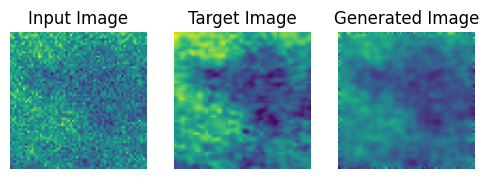

2024-06-27 11:07:08.857076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 33.01batch/s, Val Loss=0.000485, PSNR=34.5, MSE=0.000485]


Epoch 2/9, Loss: 0.0005234297132119536, Val Loss: 0.0004850390541832894, PSNR: 34.46403884887695, MSE: 0.0004850391123909503


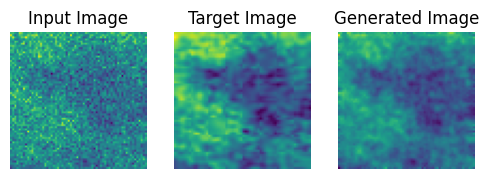

2024-06-27 11:07:24.658614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 31.12batch/s, Val Loss=0.000427, PSNR=34.9, MSE=0.000427]


Epoch 3/9, Loss: 0.00043888992513529956, Val Loss: 0.00042711972491815686, PSNR: 34.8651237487793, MSE: 0.0004271197540219873


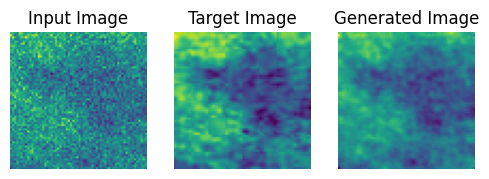

2024-06-27 11:07:40.819733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.25batch/s, Val Loss=0.000407, PSNR=35.2, MSE=0.000407]


Epoch 4/9, Loss: 0.0004070847062394023, Val Loss: 0.00040693217306397855, PSNR: 35.15937042236328, MSE: 0.000406932202167809


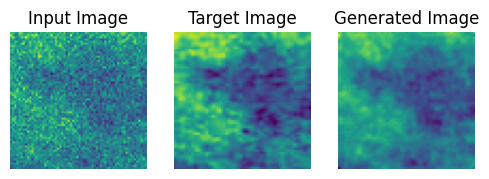

2024-06-27 11:07:57.361296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.46batch/s, Val Loss=0.000385, PSNR=35.4, MSE=0.000385]


Epoch 5/9, Loss: 0.00039103705785237253, Val Loss: 0.0003853003727272153, PSNR: 35.36589813232422, MSE: 0.0003853003727272153


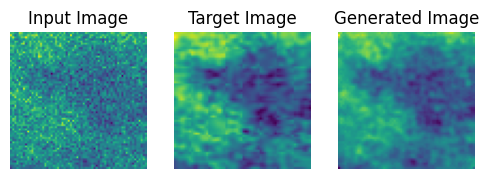

2024-06-27 11:08:14.093609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.40batch/s, Val Loss=0.000377, PSNR=35.5, MSE=0.000377]


Epoch 6/9, Loss: 0.00038375056465156376, Val Loss: 0.0003769581380765885, PSNR: 35.483436584472656, MSE: 0.0003769581380765885


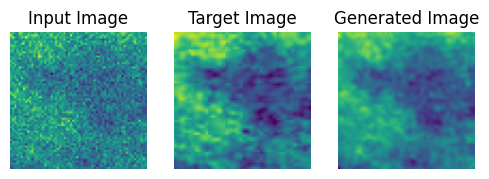

2024-06-27 11:08:30.870185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.55batch/s, Val Loss=0.000372, PSNR=35.6, MSE=0.000372]


Epoch 7/9, Loss: 0.0003735058999154717, Val Loss: 0.00037209014408290386, PSNR: 35.561607360839844, MSE: 0.0003720902022905648


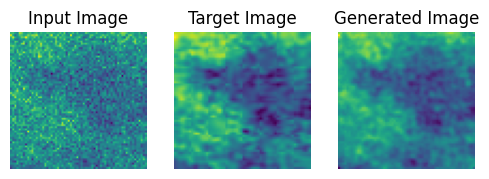

2024-06-27 11:08:47.618653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.46batch/s, Val Loss=0.000373, PSNR=35.5, MSE=0.000373]


Epoch 8/9, Loss: 0.00037290071486495435, Val Loss: 0.0003730022581294179, PSNR: 35.53532791137695, MSE: 0.0003730023163370788


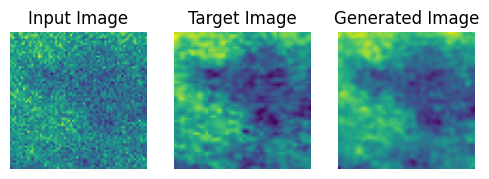

2024-06-27 11:09:04.386831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 30.36batch/s, Val Loss=0.000373, PSNR=35.6, MSE=0.000373]


Epoch 9/9, Loss: 0.00036725334939546883, Val Loss: 0.0003726429713424295, PSNR: 35.60325241088867, MSE: 0.0003726429713424295


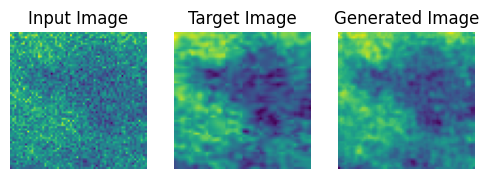

2024-06-27 11:09:21.206498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [70]:
EPOCHS = 9
history_dncnn = train_dncnn(model, train_dataset, val_dataset, EPOCHS)


Although the results obtained were quite satisfactory, experimentation continues by doubling the number of filters from 64 to 128.

In [71]:
model = build_dncnn((64,64,1),128,10)
model.summary()

Model: "DnCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      1,280 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_13[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_14[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_15[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_16[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_17[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_18[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 64, 64,    │          0 │ conv2d_20[0][0] 

 Total params: 1,625,857 (6.20 MB)

 Trainable params: 1,625,857 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Epoch 1/9 [Validation]: 100%|██████████| 51/51 [00:04<00:00, 12.06batch/s, Val Loss=0.000561, PSNR=33.8, MSE=0.000561]


Epoch 1/9, Loss: 0.0010457008611410856, Val Loss: 0.0005611859378404915, PSNR: 33.80659103393555, MSE: 0.0005611859960481524


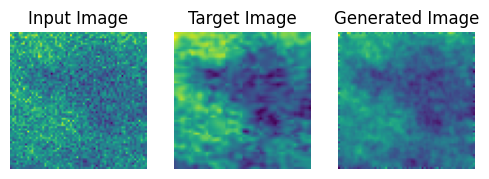

2024-06-27 11:10:12.215259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.09batch/s, Val Loss=0.000433, PSNR=34.9, MSE=0.000433]


Epoch 2/9, Loss: 0.0004678953264374286, Val Loss: 0.0004330480587668717, PSNR: 34.88999938964844, MSE: 0.0004330479714553803


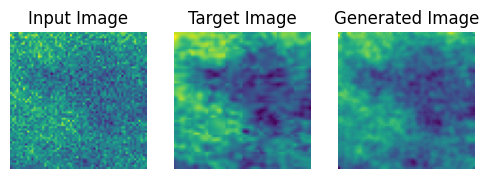

2024-06-27 11:10:50.265506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.11batch/s, Val Loss=0.000388, PSNR=35.4, MSE=0.000388]


Epoch 3/9, Loss: 0.0003994508006144315, Val Loss: 0.0003881292068399489, PSNR: 35.37606430053711, MSE: 0.000388129148632288


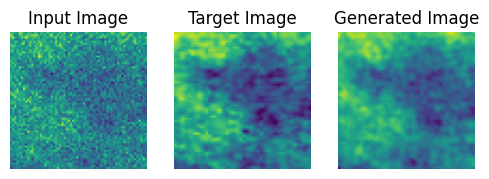

2024-06-27 11:11:28.499161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.01batch/s, Val Loss=0.000377, PSNR=35.5, MSE=0.000377]


Epoch 4/9, Loss: 0.00038141218828968704, Val Loss: 0.0003770483599510044, PSNR: 35.46528244018555, MSE: 0.00037704838905483484


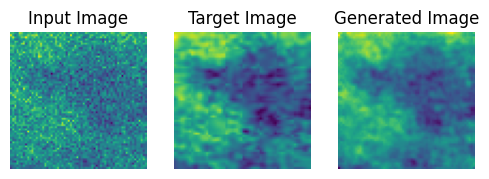

2024-06-27 11:12:06.597910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.14batch/s, Val Loss=0.000376, PSNR=35.6, MSE=0.000376]


Epoch 5/9, Loss: 0.0003682011738419533, Val Loss: 0.00037555041490122676, PSNR: 35.62495040893555, MSE: 0.00037555041490122676


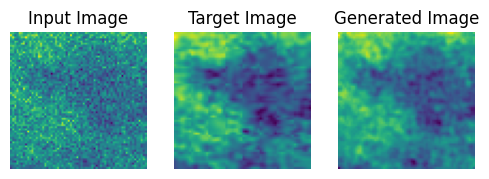

2024-06-27 11:12:44.669001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.09batch/s, Val Loss=0.000382, PSNR=35.4, MSE=0.000382]


Epoch 6/9, Loss: 0.00036609836388379335, Val Loss: 0.00038174522342160344, PSNR: 35.387577056884766, MSE: 0.0003817453689407557


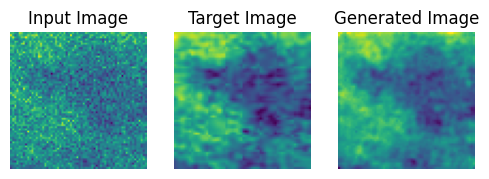

2024-06-27 11:13:22.755743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.11batch/s, Val Loss=0.000372, PSNR=35.6, MSE=0.000372]


Epoch 7/9, Loss: 0.00036059084231965244, Val Loss: 0.00037189217982813716, PSNR: 35.6425895690918, MSE: 0.0003718921507243067


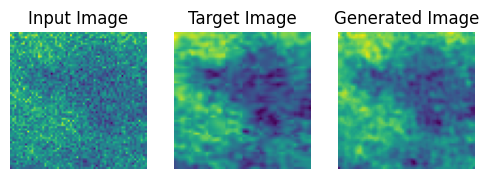

2024-06-27 11:14:00.721345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.09batch/s, Val Loss=0.000345, PSNR=35.9, MSE=0.000345]


Epoch 8/9, Loss: 0.00035118809319101274, Val Loss: 0.0003450454387348145, PSNR: 35.91279220581055, MSE: 0.0003450455260463059


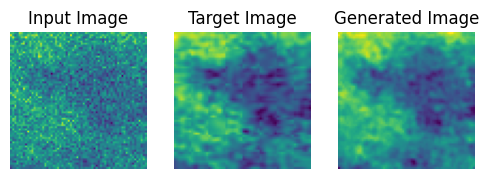

2024-06-27 11:14:38.678628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 14.19batch/s, Val Loss=0.000348, PSNR=35.8, MSE=0.000348]


Epoch 9/9, Loss: 0.00035117464722134173, Val Loss: 0.00034847186179831624, PSNR: 35.838531494140625, MSE: 0.0003484718326944858


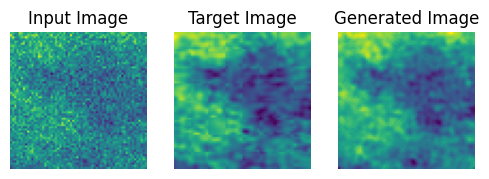

2024-06-27 11:15:16.667164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [73]:
EPOCHS = 9
history_dncnn = train_dncnn(model, train_dataset, val_dataset, EPOCHS)


Further analysis could involve exploring alternative approaches, such as employing a different loss function like Huber Loss, which combines Mean Absolute Error (MAE) with Mean Squared Error (MSE) and exhibits reduced sensitivity to outliers compared to MSE. Additionally, adjustments could be made to the number of layers and filters.

**It should be noted that these approaches have not been implemented to allow testing of another architecture.**

In [74]:
def evaluate_model_dncnn(model, test_ds):
    test_loss_avg = tf.keras.metrics.Mean()
    test_psnr_avg = tf.keras.metrics.Mean()
    test_mse_avg = tf.keras.metrics.Mean()

    for test_input_image, test_target, _ in test_ds:
        test_output = model(test_input_image, training=False)
        test_loss = loss_fn(test_target, test_output)
        test_loss_avg.update_state(test_loss)

        test_output_np = test_output.numpy()
        test_target_np = test_target.numpy()

        psnr_value = psnr(test_target_np[0], test_output_np[0])
        mse_value = mse(test_target_np[0], test_output_np[0])

        test_psnr_avg.update_state(psnr_value)
        test_mse_avg.update_state(mse_value)

    print(f'Test Loss: {test_loss_avg.result().numpy()}, Test PSNR: {test_psnr_avg.result().numpy()}, Test MSE: {test_mse_avg.result().numpy()}')

evaluate_model_dncnn(model, test_dataset)

/tmp/ipykernel_2740407/1524579442.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(test_target_np[0], test_output_np[0])


Test Loss: 0.00034056074218824506, Test PSNR: 35.93120574951172, Test MSE: 0.00034056074218824506


2024-06-27 11:15:54.635005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [75]:
model.save('models/model1.keras')

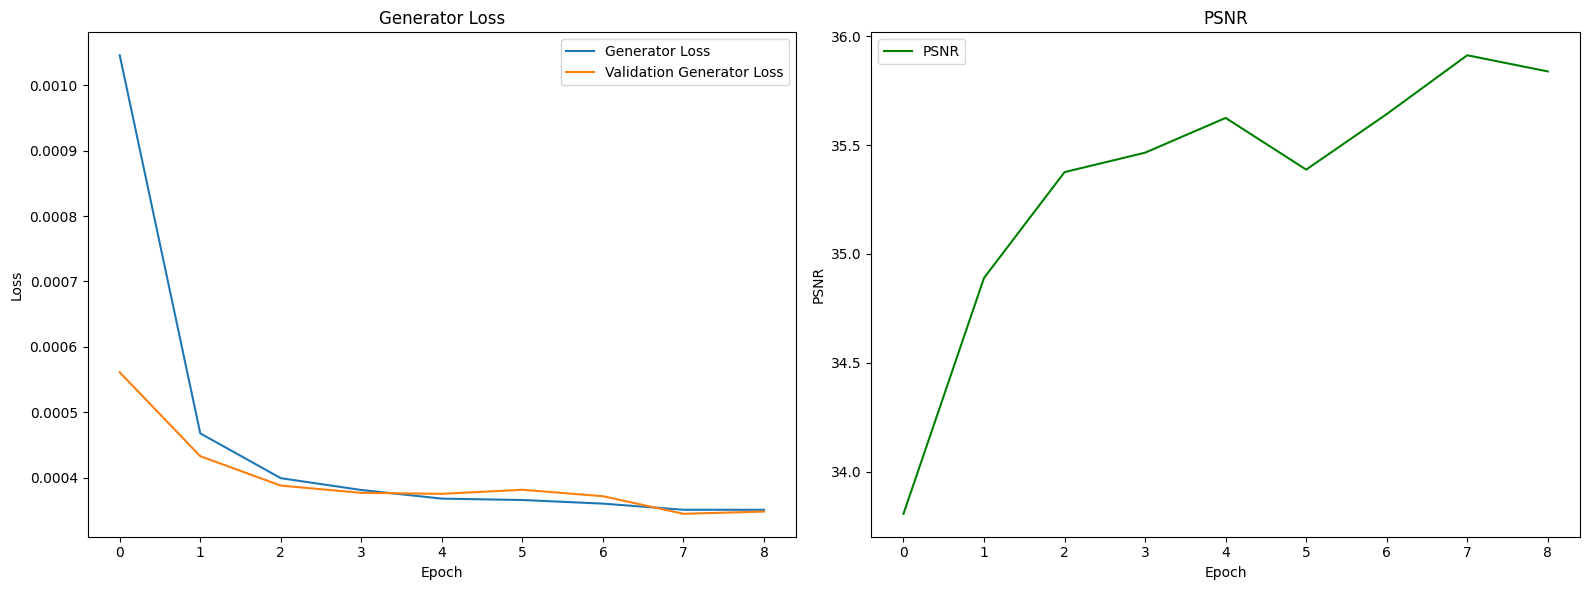

In [76]:
plot_history(history_dncnn)

In [77]:
metrics = calculate_metrics_dl(test_dataset, model)

Calculating metrics:   0%|          | 0/1606 [00:00<?, ?it/s]/tmp/ipykernel_2740407/3275622435.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_score = psnr(target.squeeze(), generated_image.squeeze())
Calculating metrics: 100%|██████████| 1606/1606 [00:21<00:00, 75.79it/s]


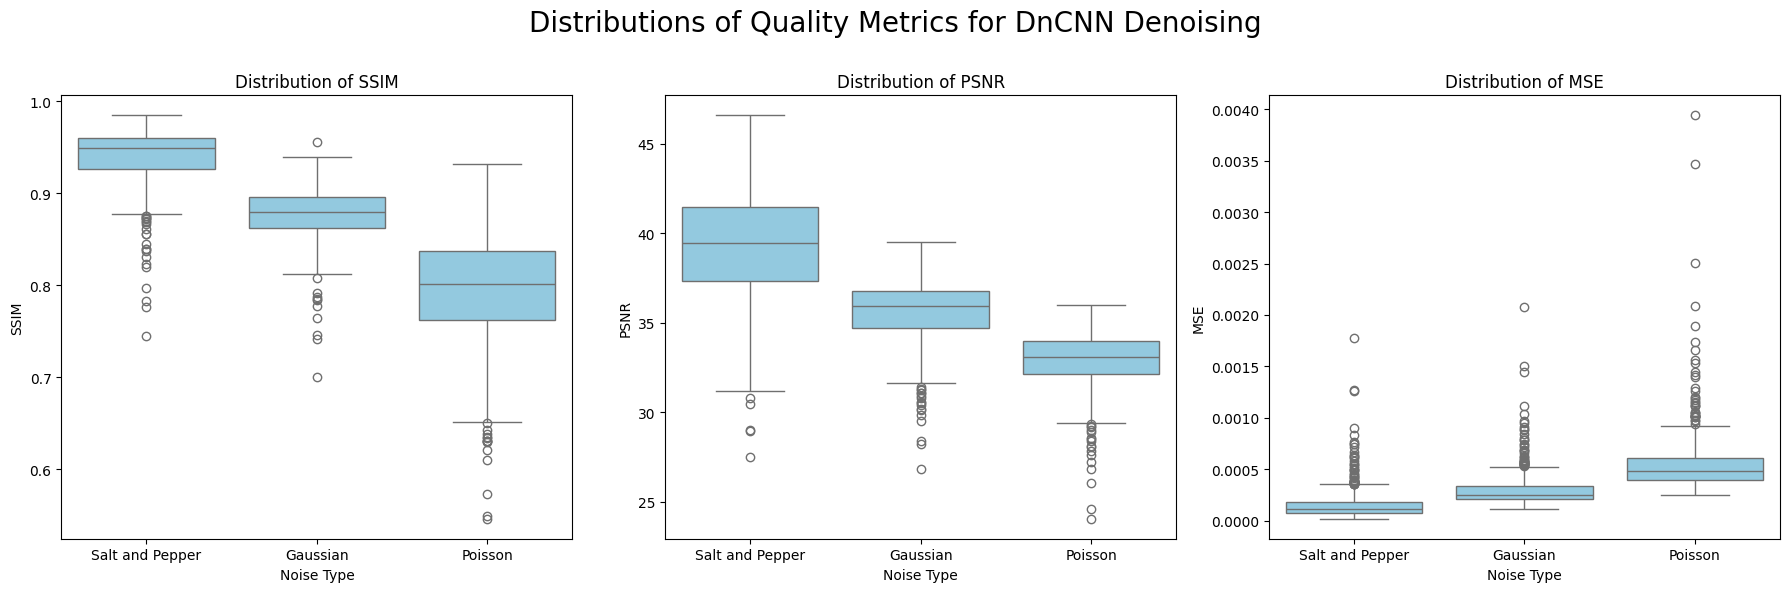

In [78]:
ssim_values = []
psnr_values = []
mse_values = []
noise_labels = []

for noise_type, values in metrics.items():
    ssim_values.extend(values['ssim'])
    psnr_values.extend(values['psnr'])
    mse_values.extend(values['mse'])
    noise_labels.extend([noise_type] * len(values['ssim']))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for DnCNN Denoising', fontsize=20)

sns.boxplot(x=noise_labels, y=ssim_values, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of SSIM')
axes[0].set_xlabel('Noise Type')
axes[0].set_ylabel('SSIM')

sns.boxplot(x=noise_labels, y=psnr_values, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of PSNR')
axes[1].set_xlabel('Noise Type')
axes[1].set_ylabel('PSNR')

sns.boxplot(x=noise_labels, y=mse_values, ax=axes[2], color='skyblue')
axes[2].set_title('Distribution of MSE')
axes[2].set_xlabel('Noise Type')
axes[2].set_ylabel('MSE')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [79]:
mean_ssim = {noise_type: np.mean(metrics[noise_type]['ssim']) for noise_type in metrics}
mean_psnr = {noise_type: np.mean(metrics[noise_type]['psnr']) for noise_type in metrics}
mean_mse = {noise_type: np.mean(metrics[noise_type]['mse']) for noise_type in metrics}

median_ssim = {noise_type: np.median(metrics[noise_type]['ssim']) for noise_type in metrics}
median_psnr = {noise_type: np.median(metrics[noise_type]['psnr']) for noise_type in metrics}
median_mse = {noise_type: np.median(metrics[noise_type]['mse']) for noise_type in metrics}

print("Mean SSIM:")
for noise_type, mean in mean_ssim.items():
    print(f"{noise_type}: {mean}")

print("\nMedian SSIM:")
for noise_type, median in median_ssim.items():
    print(f"{noise_type}: {median}")

print("\nMean PSNR:")
for noise_type, mean in mean_psnr.items():
    print(f"{noise_type}: {mean}")

print("\nMedian PSNR:")
for noise_type, median in median_psnr.items():
    print(f"{noise_type}: {median}")

print("\nMean MSE:")
for noise_type, mean in mean_mse.items():
    print(f"{noise_type}: {mean}")

print("\nMedian MSE:")
for noise_type, median in median_mse.items():
    print(f"{noise_type}: {median}")

Mean SSIM:
Salt and Pepper: 0.9403872505628894
Gaussian: 0.8779115429286373
Poisson: 0.7961895479104962

Median SSIM:
Salt and Pepper: 0.9489658366392207
Gaussian: 0.8795242824243193
Poisson: 0.8013241170215348

Mean PSNR:
Salt and Pepper: 39.25657120102307
Gaussian: 35.65906490217363
Poisson: 32.858266243799854

Median PSNR:
Salt and Pepper: 39.46984596807549
Gaussian: 35.92613256153819
Poisson: 33.10814128244097

Mean MSE:
Salt and Pepper: 0.0001582983146728587
Gaussian: 0.0003019088226298082
Poisson: 0.0005623525718075502

Median MSE:
Salt and Pepper: 0.00011298368322522611
Gaussian: 0.0002554975522726517
Poisson: 0.0004888615402439655


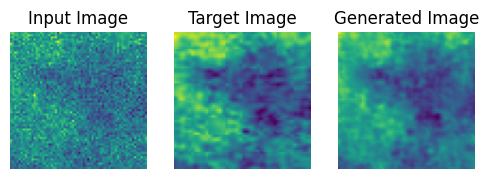


#### Poisson Noise

For Poisson Noise, the Mean Filter was identified as the best performing conventional filter. However, the DnCNN model clearly outperforms it, achieving an average SSIM improvement from 0.699 to 0.801 and a PSNR (mean) improvement from 30.71dB to 32.86dB.


#### Salt and Pepper Noise

When dealing with Salt and Pepper Noise, the Median Filter was found to be the most effective conventional filter. Here again, the DnCNN model demonstrates superior performance, with an average SSIM improvement from 0.913 to 0.948 and an average PSNR improvement from 37.94dB to 39.25dB.

#### Gaussian Noise

In the case of Gaussian Noise, the Anisotropic Filter was identified as the best conventional filter. The DnCNN model shows comparable performance but slightly better results, with SSIM improving from 0.875 to 0.877 and PSNR from 35.58dB to 35.65dB.

#### **In summary**
Across all types of analyzed noise—Poisson, Salt and Pepper, and Gaussian—the DnCNN model consistently outperforms conventional filters in terms of both SSIM and PSNR metrics. This indicates that the DnCNN model is particularly effective in denoising images corrupted by different types of noise, showcasing improvements in image quality and fidelity compared to traditional denoising filters.

### U-Net Approach

The U-Net approach is a deep neural network architecture primarily used for biomedical image segmentation, introduced in the paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation" published in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox.

This architecture was designed to address the challenge of segmenting biomedical images, where the goal is to separate and identify different structures within images, such as organs, tissues, or other regions of interest. The name "U-Net" comes from the U-shaped architecture of the neural network, characterized by a contracting path followed by an expanding path, which helps capture details at different scales within the image.

In [80]:
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate

**Encoder**

The input image undergoes a series of convolutional layers followed by max-pooling operations.
Convolutional layers are responsible for extracting feature maps. Here, each convolutional layer is followed by a Rectified Linear Unit (ReLU) activation function to introduce non-linearity, helping the model learn complex patterns in the data.
Max-pooling layers reduce the spatial dimensions of the feature maps, increasing the receptive field and capturing more abstract features as we move deeper into the network.

**Bottleneck**

After several downsampling steps through the encoder, the network reaches a bottleneck.
The bottleneck consists of two consecutive convolutional layers with a large number of filters, aiming to capture the most abstract representations of the input image.

**Decoder**

The decoder path starts with upsampling followed by concatenation with the corresponding feature maps from the encoder path.
Upsampling layers increase the spatial dimensions of the feature maps to reconstruct the original image resolution.
Concatenation allows the network to refine the feature maps by combining high-resolution information from the encoder with the abstract representations learned in the bottleneck.

**Output Layer**

The final layer uses a convolutional layer to produce the segmentation mask for the input image.

In [96]:
def build_unet(input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 3, activation='sigmoid', padding='same')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model1 = build_unet()
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_94[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_95[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_96[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_98[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 8, 8, 256) │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 8, 8, 512) │  2,359,808 │ conv2d_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_14    │ (None, 16, 16,    │          0 │ conv2d_101[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 16, 16,    │          0 │ up_sampling2d_14… │
│ (Concatenate)       │ 768)              │            │ conv2d_99[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 16, 16,    │  1,769,728 │ concatenate_14[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 16, 16,    │    590,080 │ conv2d_102[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (None, 32, 32,    │          0 │ conv2d_103[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,782,273 (29.69 MB)

 Trainable params: 7,782,273 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Epoch 1/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 23.15batch/s, Val Loss=0.00116, PSNR=30.7, MSE=0.00116]


Epoch 1/9, Loss: 0.01136464811861515, Val Loss: 0.0011636862764135003, PSNR: 30.731386184692383, MSE: 0.0011636862764135003


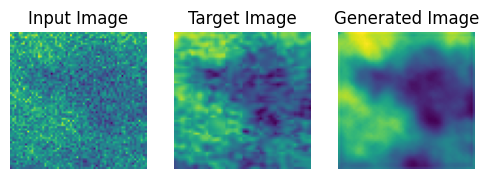

2024-06-27 11:38:29.206368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 23.35batch/s, Val Loss=0.000824, PSNR=31.5, MSE=0.000824]


Epoch 2/9, Loss: 0.0010029409313574433, Val Loss: 0.0008236971334554255, PSNR: 31.469755172729492, MSE: 0.0008236967260017991


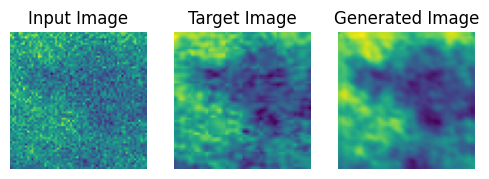

2024-06-27 11:38:48.565128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 23.63batch/s, Val Loss=0.000488, PSNR=34.1, MSE=0.000488]


Epoch 3/9, Loss: 0.000628011126536876, Val Loss: 0.00048777423216961324, PSNR: 34.1316032409668, MSE: 0.00048777417396195233


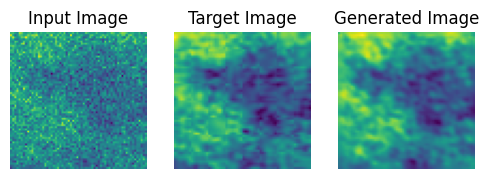

2024-06-27 11:39:08.004014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 22.85batch/s, Val Loss=0.00122, PSNR=29.8, MSE=0.00122]


Epoch 4/9, Loss: 0.000576383841689676, Val Loss: 0.0012157235760241747, PSNR: 29.810474395751953, MSE: 0.0012157242745161057


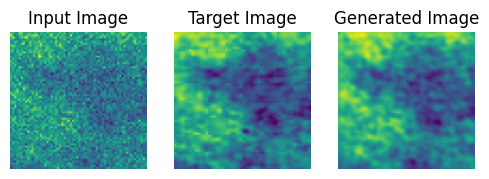

2024-06-27 11:39:27.779721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 23.48batch/s, Val Loss=0.000453, PSNR=34.5, MSE=0.000453]


Epoch 5/9, Loss: 0.0005236450233496726, Val Loss: 0.00045326852705329657, PSNR: 34.45195007324219, MSE: 0.000453268556157127


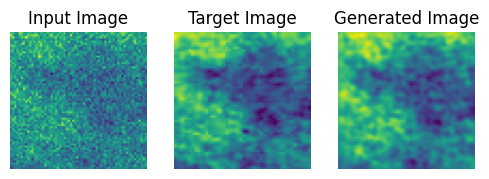

2024-06-27 11:39:47.181287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 22.72batch/s, Val Loss=0.000427, PSNR=34.7, MSE=0.000427]


Epoch 6/9, Loss: 0.0005151579971425235, Val Loss: 0.0004267284239176661, PSNR: 34.70436096191406, MSE: 0.0004267283948138356


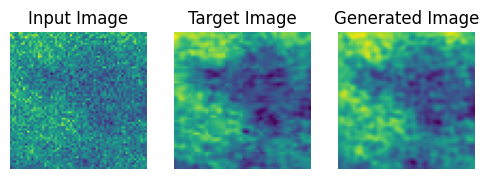

2024-06-27 11:40:07.028228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 22.42batch/s, Val Loss=0.000395, PSNR=35.1, MSE=0.000395]


Epoch 7/9, Loss: 0.00045901964767836034, Val Loss: 0.00039509779890067875, PSNR: 35.09159469604492, MSE: 0.00039509779890067875


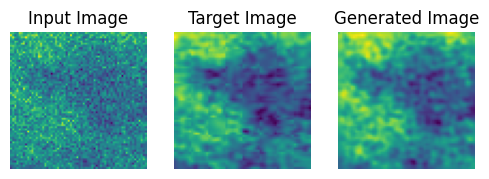

2024-06-27 11:40:27.085049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 22.77batch/s, Val Loss=0.000393, PSNR=35.2, MSE=0.000393]


Epoch 8/9, Loss: 0.0004389779642224312, Val Loss: 0.00039326632395386696, PSNR: 35.17374038696289, MSE: 0.0003932662948500365


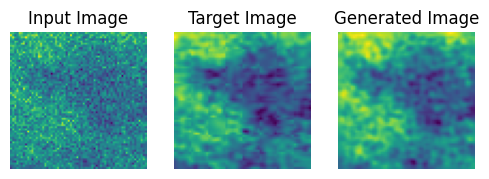

2024-06-27 11:40:46.995492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 22.88batch/s, Val Loss=0.000411, PSNR=34.9, MSE=0.000411]


Epoch 9/9, Loss: 0.000430007406976074, Val Loss: 0.00041147711453959346, PSNR: 34.907249450683594, MSE: 0.000411477085435763


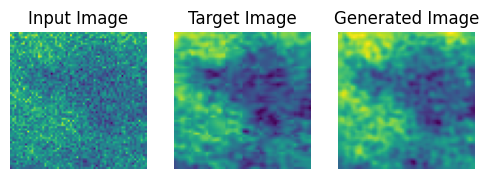

2024-06-27 11:41:06.884030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [98]:
EPOCHS = 9
history_dncnn = train_dncnn(model1, train_dataset, val_dataset, EPOCHS)


Investigate whether deeper network architectures yield improved results.

In [88]:
def build_unet(input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 3, activation='sigmoid', padding='same')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model2 = build_unet()
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_62[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_64[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 8, 8, 256) │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_66[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 4, 4, 512) │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 4, 4,      │  4,719,616 │ max_pooling2d_10… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 4, 4,      │  9,438,208 │ conv2d_68[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 8, 8,      │          0 │ conv2d_69[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 8, 8,      │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 1536)             │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,378,305 (119.70 MB)

 Trainable params: 31,378,305 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Epoch 1/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.14batch/s, Val Loss=0.000811, PSNR=32.1, MSE=0.000811]


Epoch 1/9, Loss: 0.010347024537622929, Val Loss: 0.0008114384254440665, PSNR: 32.085243225097656, MSE: 0.0008114383672364056


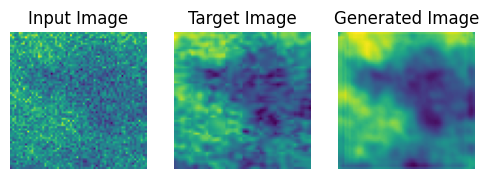

2024-06-27 11:29:44.572577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.08batch/s, Val Loss=0.000547, PSNR=33.7, MSE=0.000547]


Epoch 2/9, Loss: 0.0007281226571649313, Val Loss: 0.000547223724424839, PSNR: 33.65519714355469, MSE: 0.0005472237826324999


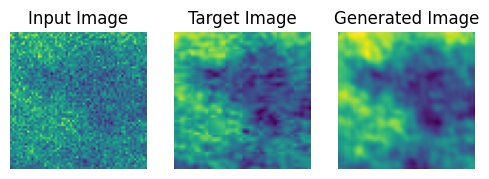

2024-06-27 11:30:13.945902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.84batch/s, Val Loss=0.000483, PSNR=34.2, MSE=0.000483]


Epoch 3/9, Loss: 0.0005614980473183095, Val Loss: 0.0004825963405892253, PSNR: 34.162139892578125, MSE: 0.0004825965443160385


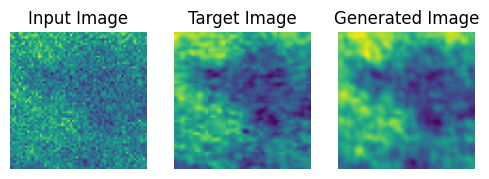

2024-06-27 11:30:42.461128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 19.73batch/s, Val Loss=0.00046, PSNR=34.4, MSE=0.00046]


Epoch 4/9, Loss: 0.0005361206131055951, Val Loss: 0.00046043674228712916, PSNR: 34.387794494628906, MSE: 0.00046043688780628145


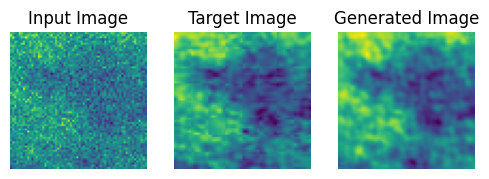

2024-06-27 11:31:10.368067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.55batch/s, Val Loss=0.000751, PSNR=31.7, MSE=0.000751]


Epoch 5/9, Loss: 0.0004884591908194125, Val Loss: 0.000751177838537842, PSNR: 31.693103790283203, MSE: 0.0007511784206144512


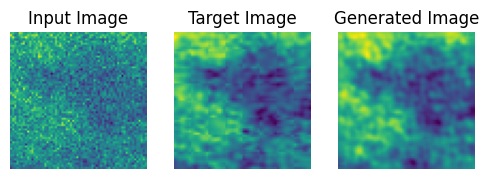

2024-06-27 11:31:38.979310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.90batch/s, Val Loss=0.000657, PSNR=32.4, MSE=0.000657]


Epoch 6/9, Loss: 0.0004983448307029903, Val Loss: 0.0006567858508788049, PSNR: 32.40717697143555, MSE: 0.0006567862001247704


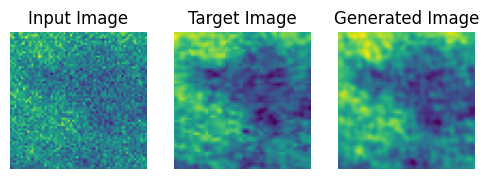

2024-06-27 11:32:07.624355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.56batch/s, Val Loss=0.000413, PSNR=34.9, MSE=0.000413]


Epoch 7/9, Loss: 0.00047154337516985834, Val Loss: 0.00041260174475610256, PSNR: 34.88421630859375, MSE: 0.0004126017156522721


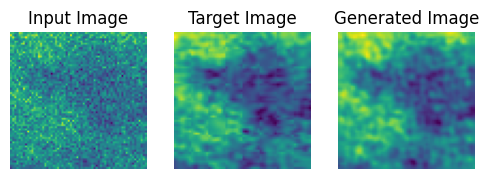

2024-06-27 11:32:36.206790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.29batch/s, Val Loss=0.000442, PSNR=34.6, MSE=0.000442]


Epoch 8/9, Loss: 0.00047642458230257034, Val Loss: 0.0004419180331751704, PSNR: 34.611663818359375, MSE: 0.0004419180331751704


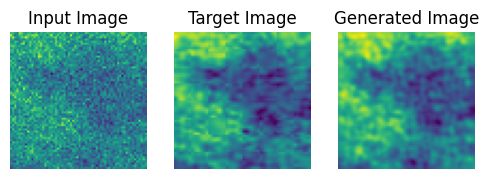

2024-06-27 11:33:04.751684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/9 [Validation]: 100%|██████████| 51/51 [00:02<00:00, 18.40batch/s, Val Loss=0.000475, PSNR=34, MSE=0.000475]


Epoch 9/9, Loss: 0.0004457647737581283, Val Loss: 0.0004754125257022679, PSNR: 33.95672607421875, MSE: 0.0004754123219754547


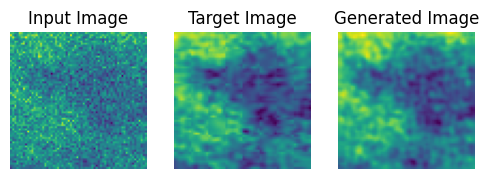

2024-06-27 11:33:33.197340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
EPOCHS = 9
history_dncnn = train_dncnn(model2, train_dataset, val_dataset, EPOCHS)


Check if a lighter architecture performs better.

In [91]:
def build_unet(input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 3, activation='sigmoid', padding='same')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model3 = build_unet()
model3.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_79[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_80[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_81[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_82[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_83[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 128) │          0 │ conv2d_84[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 8, 8, 256) │    590,080 │ conv2d_85[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 16, 16,    │          0 │ conv2d_86[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 16, 16,    │          0 │ up_sampling2d_11… │
│ (Concatenate)       │ 384)              │            │ conv2d_84[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 16, 16,    │    442,496 │ concatenate_11[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_87[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 32, 32,    │          0 │ conv2d_88[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,946,561 (7.43 MB)

 Trainable params: 1,946,561 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Epoch 1/9 [Validation]: 100%|██████████| 51/51 [00:03<00:00, 16.82batch/s, Val Loss=0.00184, PSNR=29.2, MSE=0.00184]

Epoch 1/9, Loss: 0.016957934945821762, Val Loss: 0.0018414126243442297, PSNR: 29.22432518005371, MSE: 0.0018414127407595515


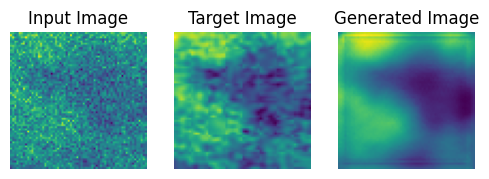

2024-06-27 11:36:09.059828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.12batch/s, Val Loss=0.000886, PSNR=31.9, MSE=0.000886]


Epoch 2/9, Loss: 0.0013922143261879683, Val Loss: 0.0008855697233229876, PSNR: 31.86313247680664, MSE: 0.0008855697233229876


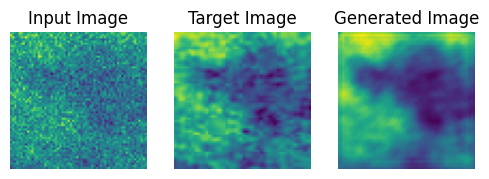

2024-06-27 11:36:18.361204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.28batch/s, Val Loss=0.000701, PSNR=32.6, MSE=0.000701]


Epoch 3/9, Loss: 0.0008210349478758872, Val Loss: 0.0007011283887550235, PSNR: 32.603572845458984, MSE: 0.0007011283305473626


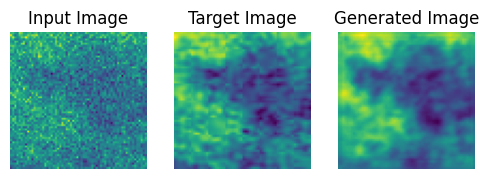

2024-06-27 11:36:27.683749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.03batch/s, Val Loss=0.000524, PSNR=33.8, MSE=0.000524]


Epoch 4/9, Loss: 0.0006123775965534151, Val Loss: 0.0005242389161139727, PSNR: 33.8139762878418, MSE: 0.0005242389161139727


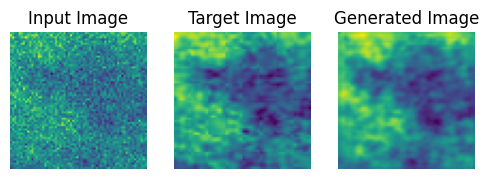

2024-06-27 11:36:37.034039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.71batch/s, Val Loss=0.000492, PSNR=34.1, MSE=0.000492]


Epoch 5/9, Loss: 0.0006015959661453962, Val Loss: 0.0004920193459838629, PSNR: 34.11209487915039, MSE: 0.0004920193459838629


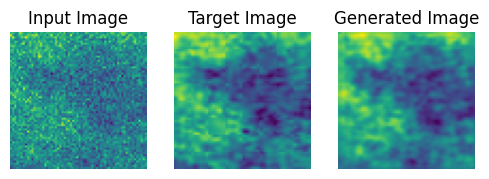

2024-06-27 11:36:46.445321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 31.88batch/s, Val Loss=0.000486, PSNR=34, MSE=0.000486]


Epoch 6/9, Loss: 0.0005319310002960265, Val Loss: 0.00048627026262693107, PSNR: 34.0434455871582, MSE: 0.000486270320834592


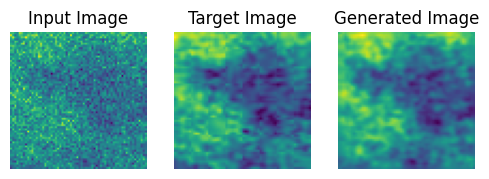

2024-06-27 11:36:55.809378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.02batch/s, Val Loss=0.000554, PSNR=33.2, MSE=0.000554]


Epoch 7/9, Loss: 0.0004847819509450346, Val Loss: 0.0005543594597838819, PSNR: 33.18535614013672, MSE: 0.0005543599254451692


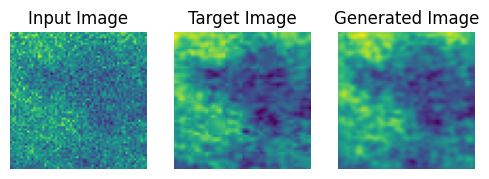

2024-06-27 11:37:05.194102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 32.27batch/s, Val Loss=0.00044, PSNR=34.6, MSE=0.00044]


Epoch 8/9, Loss: 0.00047746216296218336, Val Loss: 0.00043990692938677967, PSNR: 34.56513595581055, MSE: 0.0004399069584906101


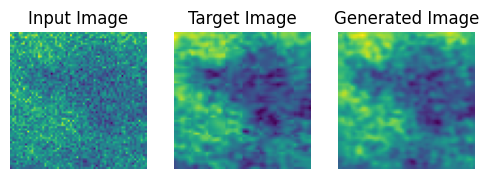

2024-06-27 11:37:14.584291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/9 [Validation]: 100%|██████████| 51/51 [00:01<00:00, 33.03batch/s, Val Loss=0.000431, PSNR=34.6, MSE=0.000431]


Epoch 9/9, Loss: 0.00046349471085704863, Val Loss: 0.0004309765063226223, PSNR: 34.640689849853516, MSE: 0.00043097653542645276


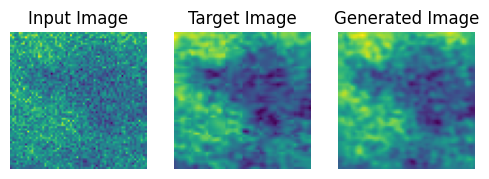

2024-06-27 11:37:23.897654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [93]:
EPOCHS = 9
history_dncnn = train_dncnn(model3, train_dataset, val_dataset, EPOCHS)


In [99]:
model1.save('models/model2.keras')

In [100]:
metrics = calculate_metrics_dl(test_dataset, model1)

Calculating metrics:   0%|          | 0/1606 [00:00<?, ?it/s]/tmp/ipykernel_2740407/3275622435.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_score = psnr(target.squeeze(), generated_image.squeeze())
Calculating metrics: 100%|██████████| 1606/1606 [00:39<00:00, 40.30it/s]


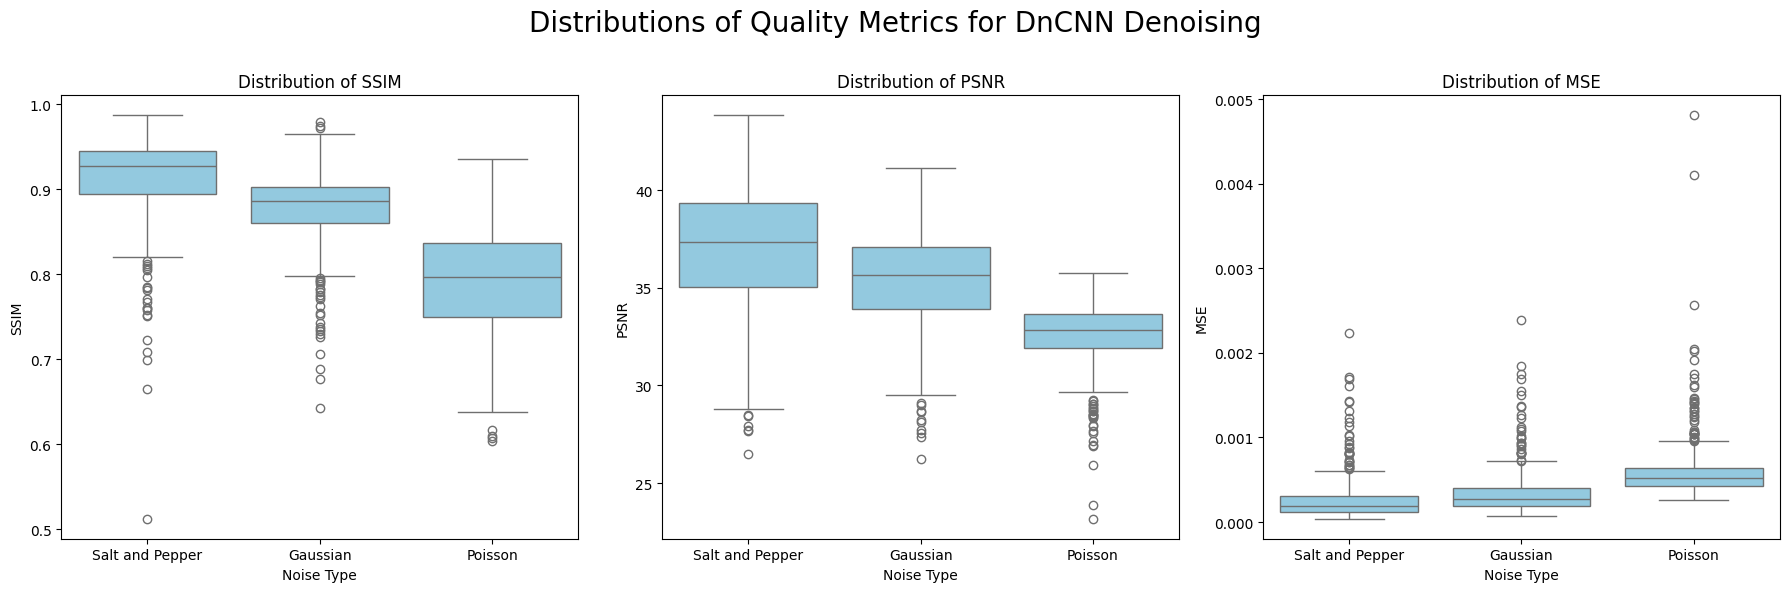

In [101]:
ssim_values = []
psnr_values = []
mse_values = []
noise_labels = []

for noise_type, values in metrics.items():
    ssim_values.extend(values['ssim'])
    psnr_values.extend(values['psnr'])

    mse_values.extend(values['mse'])
    noise_labels.extend([noise_type] * len(values['ssim']))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distributions of Quality Metrics for DnCNN Denoising', fontsize=20)

sns.boxplot(x=noise_labels, y=ssim_values, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of SSIM')
axes[0].set_xlabel('Noise Type')
axes[0].set_ylabel('SSIM')

sns.boxplot(x=noise_labels, y=psnr_values, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of PSNR')
axes[1].set_xlabel('Noise Type')
axes[1].set_ylabel('PSNR')

sns.boxplot(x=noise_labels, y=mse_values, ax=axes[2], color='skyblue')
axes[2].set_title('Distribution of MSE')
axes[2].set_xlabel('Noise Type')
axes[2].set_ylabel('MSE')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [102]:
mean_ssim = {noise_type: np.mean(metrics[noise_type]['ssim']) for noise_type in metrics}
mean_psnr = {noise_type: np.mean(metrics[noise_type]['psnr']) for noise_type in metrics}
mean_mse = {noise_type: np.mean(metrics[noise_type]['mse']) for noise_type in metrics}

median_ssim = {noise_type: np.median(metrics[noise_type]['ssim']) for noise_type in metrics}
median_psnr = {noise_type: np.median(metrics[noise_type]['psnr']) for noise_type in metrics}
median_mse = {noise_type: np.median(metrics[noise_type]['mse']) for noise_type in metrics}

print("Mean SSIM:")
for noise_type, mean in mean_ssim.items():
    print(f"{noise_type}: {mean}")

print("\nMedian SSIM:")
for noise_type, median in median_ssim.items():
    print(f"{noise_type}: {median}")

print("\nMean PSNR:")
for noise_type, mean in mean_psnr.items():
    print(f"{noise_type}: {mean}")

print("\nMedian PSNR:")
for noise_type, median in median_psnr.items():
    print(f"{noise_type}: {median}")

print("\nMean MSE:")
for noise_type, mean in mean_mse.items():
    print(f"{noise_type}: {mean}")

print("\nMedian MSE:")
for noise_type, median in median_mse.items():
    print(f"{noise_type}: {median}")

Mean SSIM:
Salt and Pepper: 0.9137008975653589
Gaussian: 0.8774933657572266
Poisson: 0.7918219039344307

Median SSIM:
Salt and Pepper: 0.9270179094934432
Gaussian: 0.8865409495271773
Poisson: 0.7971393680766335

Mean PSNR:
Salt and Pepper: 37.0093508343541
Gaussian: 35.36147146663551
Poisson: 32.59736487651217

Median PSNR:
Salt and Pepper: 37.33260086186144
Gaussian: 35.67310519873984
Poisson: 32.82550976198304

Mean MSE:
Salt and Pepper: 0.0002617032567450154
Gaussian: 0.00034412134356380834
Poisson: 0.0005995513784035047

Median MSE:
Salt and Pepper: 0.0001848162405758414
Gaussian: 0.000270825454171189
Poisson: 0.0005217338610714889


#### Poisson Noise

For Poisson Noise, the Mean Filter was identified as the best performing conventional filter. However, the U-Net model clearly outperforms it, achieving an average SSIM improvement from 0.699 to 0.791 and a PSNR (mean) improvement from 30.71dB to 32.59dB.


#### Salt and Pepper Noise

In cases of Salt and Pepper Noise where Median Filters are conventionally effective, the U-Net model exhibits relatively lower performance, showing the same average SSIM of 0.913 and a PSNR decrease from 37.94dB to 37.01dB. While traditional filters excel in mitigating this specific type of noise, the U-Net model achieve comparable results.


#### Gaussian Noise

In the case of Gaussian Noise, the Anisotropic Filter was identified as the best conventional filter. The U-Net model shows comparable performance results, with SSIM improving from 0.875 to 0.878 and PSNR drecreasing from 35.58dB to 35.36dB.

#### **In summary**
The U-Net overpeforms classic filters in scenarios like Poisson Noise, there remains potential for further refinement to improve performance in handling Salt and Pepper Noise and Gaussian Noise.

### Limitations and Further Analysis

Given the available time, only two network architectures were explored, while numerous others have been proposed over the years for image denoising. For instance, notable architectures include those described in the papers by *Zhang et al. (2017) Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising*, it is designed for image denoising using deep convolutional layers with skip connections to preserve fine details, and *Lehtinen et al. (2018) Noise2Noise: Learning Image Restoration without Clean Data* that combines generative adversarial networks (GANs) with denoising techniques to enhance image quality by removing noise.

Due to computational complexity, it was not feasible to utilize all available 64x64 patches. Increasing the amount of data likely would have positively influenced the results, achievable also through Data Augmentation strategies.

Introducing other types of noise, as mentioned earlier, could have aided the network in recognizing additional patterns, thereby enhancing generalization capabilities.